---
## **Single Cell Proteomics Meta-Analysis**
### **Author**: Gerard Font
**Date:** January 2025<br>
**MBDS** - Master Biomedical Data Science

Meta-analysis, is a statistical technique that combines and analyzes data from multiple independent studies, which has become increasingly important in the field of single-cell proteomics. By integrating data from different experiments, meta-analysis allows for the identification of robust and reproducible findings, overcoming the limitations of individual studies and providing a more comprehensive view of the biological landscape.

The objectives of this thesis are as follows:
1. Review and summarize the existing literature on single-cell proteomics and meta-analysis.
2. Collect and curate relevant single-cell proteomic datasets from public repositories.
3. Develop a comprehensive data analysis pipeline for meta-analysis of single-cell proteomic data.
4. Apply the developed pipeline to integrate and analyze the collected datasets.
5. Identify differentially expressed proteins, cellular subpopulations, and potential biomarkers.
6. Validate the findings through comparison with independent datasets and experimental validation.
7. Interpret the results and provide biological insights into the studied biological systems.

Through this master thesis, I hope to provide a comprehensive overview of the data analysis techniques employed in single-cell proteomics meta-analysis and demonstrate their utility in uncovering novel biological insights.


**Cell types**<br><br>
The notebook and the meta-analysis are centered on examining experiments that utilize human monocytes and macrophages, specifically focusing on the M0, M1, and M2 phenotypes. These studies are crucial for understanding the functional differentiation and polarization of monocytes into macrophages, which play vital roles in immune response and inflammation. By analyzing the proteomic profiles and comparing the abundance of proteins in these different macrophage states, the research aims to uncover key regulatory mechanisms and potential biomarkers that influence macrophage behavior and their responses to various stimuli. This comprehensive approach provides valuable insights into macrophage biology and their roles in health and disease.

* **M0** - Undifferentiated macrophages or monocytes
* **M1** - Classically activated macrophages (stimulated with LPS, IFN-γ, etc)
* **M2** - Alternatively activated macrophages (stimulated with IL-4, IL-13, etc) 
<br>

---
## Introduction and Data Preparation


### Import required Libraries


In [1]:
# Import pandas
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

# Venn diagram
from matplotlib_venn import venn3
from matplotlib_venn import venn2

# Core scverse libraries
import scanpy as sc
import anndata as ad
import numpy as np

from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Gerard's libraries
from src.uniprot_client import UniprotClient
from src.stringdb_client import StringDBClient

from IPython.display import Image, display
from IPython.core.display import display, HTML

import warnings 

import gseapy as gp
from gseapy import barplot, dotplot
from gseapy import enrichment_map

import networkx as nx
from pyvis.network import Network



/Users/gerardfont/Documents/Gerard/Master_BiomedicalDataScience/00_Master_THESIS/code/pyMSpro/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/var/folders/nb/8pkj_syd5t57qn6g_bqjjp440000gn/T/ipykernel_80978/3056926222.py:24: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


___
### Configuration 

General configuration

In [2]:
uniprot = UniprotClient()

TRANSLATE_PROTEIN_ID = False     # True to use UniprotKB API to translate all protein ID's. False to use the already translated files stored in uniprot_out folder

# Filtering thresholds
MIN_NUM_PEPTIDE_THRESHOLD = 2   # Minimum number of peptides required to consider a protein as identified
PSM_THRESHOLD = 5               # Minimum number of PSMs required to consider a protein as identified
SCORE_THRESHOLD = 1.5           # Minimum score required to consider a protein as identified

TOP_GENES = 25                  

# Differential Expression Analysis (DEA) Thresholds
LOG2_THRESHOLD = 0.5            # Low threshold as the data contains few cells
PVAL_THRESHOLD = 0.05
COMBINED_SCORE_THRESHOLD = 10

warnings.filterwarnings('ignore')

In [3]:
custom_theme = {
    "axes.facecolor": "white",
    "axes.edgecolor": "gray",
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "xtick.color": "gray",
    "ytick.color": "gray",
    "xtick.direction": "out",
    "ytick.direction": "out",
    "axes.titlesize": 9,
    "axes.labelsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.frameon": True,
    "legend.fontsize": 7,
    "font.family": "sans-serif", 
    "font.serif": "Calibri",
    "legend.title_fontsize": 8
}
"""    "axes.grid": True,
    "grid.color": ".97",
    "grid.linestyle": "-",
"""

# Apply the custom theme
sns.set_theme(style="ticks", rc=custom_theme)
sns.despine()
sns.set_palette(["#4CC9F0", "#4361EE", "#3A0CA3", "#F72585", "#7209B7", "#3A0CA3", "#4361EE", "#4CC9F0"])

# Customize font and palette
#sns.set_context("notebook", font_scale=0.9)
#sns.set_palette("colorblind")
#sns.set_palette(sns.color_palette("Paired"))
#sns.set_palette(sns.color_palette("rocket"))
#sns.set_palette(sns.color_palette("tab10"))
#sns.set_palette(sns.color_palette("tab20"))
#sns.set_palette(sns.color_palette("Spectral"))
#sns.set_palette(sns.color_palette("hls", 8)

# https://r02b.github.io/seaborn_palettes/

<Figure size 640x480 with 0 Axes>

---
### Data Sources

The meta-analysis will include the following data sources:

* **EXPERIMENT 1:** ./data/processed/2016_Iwata_ncomms12849/**SI_THP_RAW_proteomics_data_ss.xlsx**<br>
*Iwata, H., Goettsch, C., Sharma, A., Ricchiuto, P., Goh, W. W. bin, Halu, A., Yamada, I., Yoshida, H., Hara, T., Wei, M., Inoue, N., Fukuda, D., Mojcher, A., Mattson, P. C., Barabási, A. L., Boothby, M., Aikawa, E., Singh, S. A., & Aikawa, M. (2016). PARP9 and PARP14 cross-regulate macrophage activation via STAT1 ADP-ribosylation. Nature Communications 2016 7:1, 7(1), 1–19. https://doi.org/10.1038/ncomms12849*
<br><br>
* **EXPERIMENT 2:** ./data/processed/2022_Pengfei LI_35557041/**PD_Globalproteomics_2024.xlsx**<br>
*Li, P., Ma, C., Li, J., You, S., Dang, L., Wu, J., Hao, Z., Li, J., Zhi, Y., Chen, L., & Sun, S. (2022). Proteomic characterization of four subtypes of M2 macrophages derived from human THP-1 cells. Journal of Zhejiang University. Science. B, 23(5), 407–422. https://doi.org/10.1631/jzus.B2100930*
<br><br>
* **EXPERIMENT 3:** ./data/processed/2021_Pengfei LI_34267761/**THP1_global_M0_M1_M2_proteins.xlsx**<br>
*Li, P., Hao, Z., Wu, J., Ma, C., Xu, Y., Li, J., Lan, R., Zhu, B., Ren, P., Fan, D., & Sun, S. (2021). Comparative Proteomic Analysis of Polarized Human THP-1 and Mouse RAW264.7 Macrophages. Frontiers in Immunology, 12, 700009. https://doi.org/10.3389/FIMMU.2021.700009*
<br><br>
* **EXPERIMENT 4:** ./data/processed/2022_Huffman/**limmaCorrected_normed_prePCA_Priori_mrri02_PIF50_DART_1pFDR.csv** (metadata: ./data/processed/2022_Huffman/BMDM_pSCoPE_SampleGuide.csv)<br>
*Huffman, R. G., Leduc, A., Wichmann, C., di Gioia, M., Borriello, F., Specht, H., Derks, J., Khan, S., Khoury, L., Emmott, E., Petelski, A. A., Perlman, D. H., Cox, J., Zanoni, I., & Slavov, N. (2023). Prioritized mass spectrometry increases the depth, sensitivity and data completeness of single-cell proteomics. Nature Methods 2023 20:5, 20(5), 714–722. https://doi.org/10.1038/s41592-023-01830-1*
<br><br>


In [4]:
# Paths to each of the data sources
path_2016_iwata = "./data/processed/2016_Iwata_ncomms12849/SI_THP_RAW_proteomics_data_ss.xlsx"
path_2022_pengfei = "./data/processed/2022_Pengfei LI_35557041/PD_Globalproteomics_2024.xlsx"
path_2021_pengfei = "./data/processed/2021_Pengfei LI_34267761/THP1_global_M0_M1_M2_proteins.xlsx"
path_2022_huffman = "./data/processed/2022_Huffman/limmaCorrected_normed_prePCA_Priori_mrri02_PIF50_DART_1pFDR.csv"
path_2022_huffman_meta = "./data/processed/2022_Huffman/BMDM_pSCoPE_SampleGuide.csv" 

---
### Meta-analysis objectives
As part of the meta-analysis, several data analysis activities will be performed (detailed in the following table). These activities include quantitative proteomic profiling, differential expression analysis and pathway analysis. It is important to note that due to limitations in some of the data sources, not all activities may be available for every dataset. The analysis will be adapted accordingly to ensure the most comprehensive and accurate interpretation possible given the available data.

✅ **Available**<br>
🔰 **Partially available**<br>
❌ **Not available**<br><br>

<table style="text-align: center;">
  <tr style="background-color: #cccccc;">
    <th>Study</th>
    <th>Type*</th>
    <th>Method*</th>
    <th>Quantitative proteomic<br>profiling</th>
    <th>Differential Expression<br>Analysis</th>
    <th>Pathway Analysis</th>
  </tr>
  <tr>
    <td style="background-color: #efefef; text-align: left"><a href="https://www.nature.com/articles/ncomms12849" target="_blank">Iwata, H., et al. (2016)</a></td>
    <td style="background-color: #efefef;">Bulk</td>
    <td>DDA</td>
    <td>✅</td>
    <td>✅</td>
    <td>✅</td>
  </tr>
  <tr>
    <td style="background-color: #efefef; text-align: left"><a href="https://link.springer.com/article/10.1631/jzus.B2100930" target="_blank">Li, P., et al. (2022)</a></td>
    <td style="background-color: #efefef;">Bulk</td>
    <td>DDA</td>
    <td>✅</td>
    <td>✅</td>
    <td>✅</td>
  </tr>
  <tr>
    <td style="background-color: #efefef; text-align: left"><a href="https://pubmed.ncbi.nlm.nih.gov/34267761/" target="_blank">Li, P., et al. (2021)</a></td>
    <td style="background-color: #efefef;">Bulk</td>
    <td>DDA</td>
    <td>✅</td>
    <td>✅</td>
    <td>✅</td>
  </tr>

  <tr>
    <td style="background-color: #efefef; text-align: left"><a href="https://www.nature.com/articles/s41592-023-01830-1" target="_blank">Huffman, R. G., et al. (2022)</a></td>
    <td style="background-color: #efefef;">Single Cell</td>
    <td>DIA</td>
    <td>🔰</td>
    <td>✅</td>
    <td>✅</td>
  </tr>    
</table>

\**Bulk studies present in this table used cell lines and averaged the abundances of iditified proteins*
<br><br>

**Goals:**
1. Distinct Phenotypic Profiles: Understanding the unique protein profiles associated with each polarization state.
2. Shared and Unique Pathways: Pinpointing common and specific pathways that characterize different macrophage phenotypes.
<br><br><br>

**1. Top 20 Up/Down represented proteins in M1 & M2 vs M0   <->  Differential Protein Expression**
* Pairwise Comparisons: Compare M0 vs. M1, M0 vs. M2, and M1 vs. M2 to identify proteins that are upregulated or downregulated in specific polarization states.
* Fold Change Analysis: Quantify the magnitude of changes in protein expression.
* Statistical Significance: Assess the significance of changes using statistical tests like t-tests or ANOVA.

<span style="color:red">
Ideas:<br>
&#160;&#160;&#160;- Barplot with proteins found in M0, M1 and M2 (per study)<br>
&#160;&#160;&#160;- 2x Dendograms with top over/down represented proteins of M1 and M2 vs M0  (per study)<br>
&#160;&#160;&#160;- Comparison: top up/down repr. proteins found in only some of the experiments<br>
</span>

**2. Pathway Analysis (GSEA)   <->   Functional Enrichment Analysis**
* Gene Ontology (GO) Enrichment: Identify biological processes, molecular functions, and cellular components that are enriched in differentially expressed proteins.
* Pathway Analysis: Determine which signaling pathways are activated or inhibited in different polarization states.
* Protein-Protein Interaction Network Analysis: Visualize the interactions between differentially expressed proteins to identify key regulatory hubs.

---
### Load the Data

In [5]:
# EXPERIMENT 1 -----------------------------------------------------------------------------------------------------------
# Load the data from different sheets
df_2016_iwata_M0 = pd.read_excel(path_2016_iwata, sheet_name="THP_M0", index_col=0) # Index = Accession
df_2016_iwata_M1 = pd.read_excel(path_2016_iwata, sheet_name="THP_M1", index_col=0) 
df_2016_iwata_M2 = pd.read_excel(path_2016_iwata, sheet_name="THP_M2", index_col=0) 

# Merge the three datasets -----------------------------------------------------------------------------------------------
df_2016_iwata = pd.concat([df_2016_iwata_M0, df_2016_iwata_M1, df_2016_iwata_M2], keys=["M0", "M1", "M2"], names=["Type"])
df_2016_iwata = df_2016_iwata.reset_index(level=0).rename(columns={"level_0": "Type"})

# EXPERIMENT 2 -----------------------------------------------------------------------------------------------------------
df_2022_pengfei = pd.read_excel(path_2022_pengfei, sheet_name="Proteins", index_col=2) # Index = Accession

# EXPERIMENT 3 -----------------------------------------------------------------------------------------------------------
df_2021_pengfei = pd.read_excel(path_2021_pengfei, sheet_name="Proteins", index_col=5) # Index = Accession

# EXPERIMENT 4 -----------------------------------------------------------------------------------------------------------
df_huffman = pd.read_csv(path_2022_huffman, index_col=0)
df_huffman_meta = pd.read_csv(path_2022_huffman_meta, index_col=0)

# Create an AnnData object
data = df_huffman.T
df_huffman_adata = ad.AnnData(data.astype(np.float32))

# Adding metadata
anno = df_huffman_meta
ids = anno.index
anno = anno.T
celltypes = anno.iloc[2]

# New obs with the cell type
df_huffman_adata.obs['celltype'] = celltypes

# Map the cell type to the AnnData object
celltype_dict = dict(zip(ids, celltypes))
df_huffman_adata.obs['celltype'] = df_huffman_adata.obs.index.map(celltype_dict)
                              

In [6]:
# Grouping M2x types to M2 for Experiment2 by averaging
groupM2 = ['Abundances (Grouped): M2a', 'Abundances (Grouped): M2b', 'Abundances (Grouped): M2c', 'Abundances (Grouped): M2d']
df_2022_pengfei["Abundances (Grouped): M2"] = df_2022_pengfei[groupM2].mean(axis=1)

groupM2 = ['Abundance Ratio: (M2a) / (M1)', 'Abundance Ratio: (M2b) / (M1)', 'Abundance Ratio: (M2c) / (M1)', 'Abundance Ratio: (M2d) / (M1)']
df_2022_pengfei["Abundance Ratio: (M2) / (M1)"] = df_2022_pengfei[groupM2].mean(axis=1)
groupM2 = ['Abundance Ratio: (M2a) / (M0)', 'Abundance Ratio: (M2b) / (M0)', 'Abundance Ratio: (M2c) / (M0)', 'Abundance Ratio: (M2d) / (M0)']
df_2022_pengfei["Abundance Ratio: (M2) / (M0)"] = df_2022_pengfei[groupM2].mean(axis=1)

df_2022_pengfei["Abundance Ratio: (M1) / (M0)"] = df_2022_pengfei["Abundance Ratio: (M2) / (M0)"] / df_2022_pengfei["Abundance Ratio: (M2) / (M1)"]


---
### Dataset formats
Each of the files/experiments prepared a specific format that require to be adapted to make it comparable with other datasetes. These are the different formats used in the meta-analysis:


**EXPERIMENT 1: *SI_THP_RAW_proteomics_data_ss.xlsx***
* **Accession:** This is a unique identifier assigned to a protein, often from databases like UniProt or RefSeq.
* **Description:** A brief description of the protein's function or characteristics.
* **Score:** A numerical value representing the confidence level of the protein identification. Higher scores indicate more reliable identifications.
* **Coverage:** The percentage of the protein's amino acid sequence that has been covered by identified peptides.
* **#Proteins:** The number of proteins associated with the identified peptides.
* **#Unique Peptides:** The number of distinct peptide sequences identified.
* **#Peptides:** The total number of peptides identified, including duplicates.
* **#PSMs:** The number of Peptide Spectrum Matches, which represent the number of times a peptide sequence has been identified in the mass spectra.
* **126/126 Count:** Counts at moment 0hr
* **127/126 Count:** Counts at moment 8hr
* **128/126 Count:** Counts at moment 12hr
* **129/126 Count:** Counts at moment 24hr
* **130/126 Count:** Counts at moment 48hr
* **131/126 Count:** Counts at moment 72hr   <span style="color:red"><--   We take this one as a reference (fig 3. https://pmc.ncbi.nlm.nih.gov/articles/PMC7839219/)</span>

Additional information: https://www.biotech.iastate.edu/wp_biotech/wp-content/uploads/2023/07/ProteomeDiscovererInstructions.pdf
<br><br>

**EXPERIMENT 2: *PD_Globalprotomics_2024.xlsx***

* **Protein FDR Confidence: Combined**: Reflects the level of confidence in the identification of each protein
* **Master**: A unique identifier assigned to each protein group.
* **Accession**: A database accession number (e.g., UniProt) for the protein.
* **Description**: A textual description of the protein's function and characteristics.
* **Sum PEP Score**: The sum of peptide-spectrum match (PSM) scores, indicating overall confidence in protein identification.
* **# Peptides**: The number of peptides identified for the protein.
* **# PSMs**: The total number of PSMs for the protein.
* **# Protein Unique Peptides**: The number of peptides uniquely assigned to this protein.
* **# Unique Peptides**: The total number of unique peptides identified.
* **# AAs**: The number of amino acids in the protein sequence.
* **MW [kDa]**: The molecular weight of the protein in kilodaltons.
* **Score Sequest HT: Sequest HT**: The score assigned by the Sequest HT search engine for the protein identification.
* **# Razor Peptides**: The number of peptides uniquely assigned to this protein group, helping to distinguish it from other similar proteins.
* *Quantitative Proteomics Data*
    * **Abundance Ratio**: These columns represent the relative abundance of a protein in different experimental conditions (e.g., M0, M1, M2a, M2b, M2c, M2d). The ratios are calculated by dividing the abundance of a protein in one condition by the abundance in another condition.
    * **Abundances (Grouped)**: These columns represent the absolute or normalized abundance of a protein in each experimental group.
    * **Abundances (Normalized)**: These columns represent the normalized abundance of a protein in each individual sample (F1-F18). Normalization is a process to account for experimental variability and ensure accurate comparison of protein abundance across samples.
* **Modifications**: This column indicates any post-translational modifications (PTMs) identified on the protein, such as phosphorylation or acetylation.

<br><br>
**EXPERIMENT 3: *THP1_global_M0_M1_M2_proteins.xlsx***
* **Checked:** Indicates whether the protein identification was manually checked.
* **Protein FDR Confidence:** False Discovery Rate (FDR) confidence level for the protein identification.
* **Combined:** Indicates whether the protein identification is based on a combination of different search engines or data sources.
* **Master Unique Sequence ID:** A unique identifier assigned to the master protein.
* **Protein Group IDs:** Identifiers for protein groups, which can include isoforms or related proteins.
* **Accession:** Accession number from a protein database (e.g., UniProt).
* **Description:** Brief description of the protein function.
* **FASTA Title Lines:** The FASTA header line corresponding to the protein sequence.
* **Exp. q-value: Combined:** The q-value (FDR-adjusted p-value) for the protein identification.
* **Sum PEP Score:** The summed peptide expectation score for the protein.
* **# Decoy Protein: Combined:** The number of decoy proteins identified in the analysis.
* **Coverage [%]:** The percentage of the protein sequence covered by identified peptides.
* **# Peptides:** The number of peptides identified for the protein.
* **# PSMs:** The number of peptide spectrum matches (PSMs) identified.
* **# Protein Unique Peptides:** The number of peptides unique to the protein.
* **# Unique Peptides:** The number of unique peptide sequences identified.
* **# AAs:** The number of amino acids in the protein sequence.
* **MW [kDa]:** The molecular weight of the protein in kilodaltons.
* **calc. pI:** The calculated isoelectric point of the protein.
* **Score Sequest HT:** The score assigned by the Sequest HT search engine.
* **Coverage [%] (by Search Engine): Sequest HT:** The coverage by Sequest HT.
* **# PSMs (by Search Engine): Sequest HT:** The number of PSMs identified by Sequest HT.
* **# Peptides (by Search Engine): Sequest HT:** The number of peptides identified by Sequest HT.
* **# Razor Peptides:** The number of razor peptides, which are uniquely assigned to a single protein group.
* Quantitative Data:
    * **Abundance Ratio: (M1) / (M0):** The ratio of protein abundance between two conditions (M1 and M0).
    * **Abundance Ratio (log2): (M1) / (M0):** The log2-transformed abundance ratio.
    * **Abundance Ratio P-Value:** The p-value for the difference in abundance between the two conditions.
    * **Abundance Ratio Adj. P-Value:** The adjusted p-value for the abundance ratio.
    * **Abundance Ratio Variability [%]:** The variability in the abundance ratio.
    * **Abundance Ratio Weight:** The weight assigned to the abundance ratio.
    * **Abundances (Grouped): M0, M1, M2:** The grouped abundance values for each condition.
    * **Abundances (Grouped) CV [%]:** The coefficient of variation for the grouped abundance values.
    * **Abundances (Grouped) Count:** The number of replicates for each condition.
    * **Abundances (Scaled):** The scaled abundance values for each sample.
    * **Abundances (Normalized):** The normalized abundance values for each sample.
    * **Abundance:** The absolute abundance value for each sample.
    * **Abundances Count:** The number of replicates for each sample.
* Sample Information:  <span style="color:red"><-- TODO: Review </span>
    * **Found in File:** The file where the protein was identified.
    * **Found in Sample:** The sample name where the protein was identified.
    * **Found in Sample Group:** The sample group where the protein was identified.
    * **# Protein Groups:** The number of protein groups identified in the sample.
    * **Modifications:** Any identified post-translational modifications on the protein.

<br><br>
**EXPERIMENT 4: *limmaCorrected_normed_prePCA_Priori_mrri02_PIF50_DART_1pFDR.csv***  and its metadata,  *BMDM_pSCoPE_SampleGuide.csv*<br>
*Source-code: https://github.com/SlavovLab/pSCoPE*<br>

* **Processed data (proteins)**: Intensity matrix where each row represents an identified protein and each column a single cell.<br>
The final intensity matrix contains log2-transformed and normalized quantitation values for peptides or proteins across different single cell runs. Each row represents a peptide or protein, and each column represents a single cell or experimental run.

* **Metadata**. The relevant fields for this meta-analysis are
    * **id:** Cell id
    * **celltype:** Cell type ("LPS" for M1 macrophage, "untreated" for monocyte)

<br><br>
📌 **How to interpret the intensity matrix**
* **Quantitation Values:** The values in the intensity matrix represent the quantitation of peptides or proteins. These values are derived from the intensity of TMT Reporter Ions, which are used to label and quantify peptides in mass spectrometry experiments.
* **Log2 Transformation:** The quantitation values are log2-transformed to stabilize variance and make the data more normally distributed. This transformation helps in comparing fold changes and reduces the impact of extreme values.
* **Normalization:** The values are normalized to account for systematic variations between different experimental runs. This ensures that the quantitation values are comparable across different samples.
* **Imputation:** Missing values in the data are replaced with estimated values using k-nearest neighbors imputation. This step ensures that the dataset is complete and can be used for further analysis.
* **Batch Correction:** The data is corrected for batch effects using the ComBat function, which removes systematic biases introduced by different experimental batches.
<br><br><br>
Interpretation of Negative Values:<br><br>
* **Relative Quantitation**: After log2 transformation, the values in the intensity matrix represent the relative quantitation levels of peptides or proteins. A log2-transformed value of 0 indicates that the quantitation level is equal to the reference level (e.g., the normalization channel or median value).
* **Negative Values**: Negative values indicate that the quantitation level of a peptide or protein is lower than the reference level. For example, a log2-transformed value of -1 means that the quantitation level is half of the reference level (( \log_2(0.5) = -1 )).
* **Biological Significance**: In the context of single-cell proteomics, negative values can indicate lower expression levels of certain proteins in specific cells compared to the reference or median expression level. This can be important for identifying proteins that are downregulated in certain conditions or cell types.

Filters:
* Remove peptides that are more the 10% the intensity of the carrier in the single cell runs (only)

---
### Exploratory Data Analysis
Initial exploration of the datasets to understand the structure of the datasets, identify missing values, outliers, patterns,...


In [7]:
# Dimensions of the datasets
print("  Iwata, H., et al. (2016):", df_2016_iwata.shape,"-> Note that some proteins are duplicated as they are present in multiple cell types")
print("  Li, P., et al. (2022):", df_2022_pengfei.shape)
print("  Li, P., et al. (2021):", df_2021_pengfei.shape)
print("  Huffman, R. G., et al. (2022):", df_huffman_adata.shape,"-> The second dimension is the number of proteins")   

  Iwata, H., et al. (2016): (19247, 29) -> Note that some proteins are duplicated as they are present in multiple cell types
  Li, P., et al. (2022): (6616, 61)
  Li, P., et al. (2021): (7349, 109)
  Huffman, R. G., et al. (2022): (373, 1123) -> The second dimension is the number of proteins


In [8]:
# Unique proteins found in each dataest
print("  Unique proteins present in Iwata, H., et al. (2016):", df_2016_iwata.index.nunique())
print("  Unique proteins present in Li, P., et al. (2022):", df_2022_pengfei.index.nunique())
print("  Unique proteins present in Li, P., et al. (2021):", df_2021_pengfei.index.nunique())
print("  Unique proteins present in Huffman, R. G., et al. (2022):", df_huffman_adata.var.index.nunique())

  Unique proteins present in Iwata, H., et al. (2016): 9048
  Unique proteins present in Li, P., et al. (2022): 6616
  Unique proteins present in Li, P., et al. (2021): 7349
  Unique proteins present in Huffman, R. G., et al. (2022): 1123


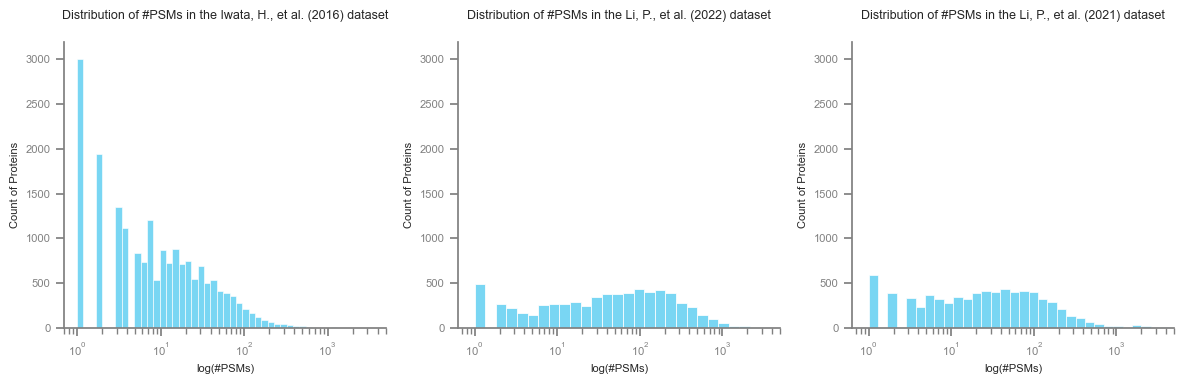

In [9]:
# Distribution of # PSMs for each dataset for exp1, exp2, exp3. 
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.histplot(df_2016_iwata["# PSMs"], log_scale=True, ax=ax[0])
sns.histplot(df_2022_pengfei["# PSMs"], log_scale=True, ax=ax[1])
sns.histplot(df_2021_pengfei["# PSMs"], log_scale=True, ax=ax[2])
ax[0].set_title("Distribution of #PSMs in the Iwata, H., et al. (2016) dataset\n")
ax[1].set_title("Distribution of #PSMs in the Li, P., et al. (2022) dataset\n")
ax[2].set_title("Distribution of #PSMs in the Li, P., et al. (2021) dataset\n")
ax[0].set_xlim([0, 5000])
ax[0].set_ylim([0, 3200])
ax[1].set_xlim([0, 5000])
ax[1].set_ylim([0, 3200])
ax[2].set_xlim([0, 5000])
ax[2].set_ylim([0, 3200])
ax[0].set_ylabel("Count of Proteins")
ax[1].set_ylabel("Count of Proteins")
ax[2].set_ylabel("Count of Proteins")
ax[0].set_xlabel("log(#PSMs)")
ax[1].set_xlabel("log(#PSMs)")
ax[2].set_xlabel("log(#PSMs)")
plt.tight_layout()
plt.show()



In [10]:
# check null values
print("Null values in the datasets")
print("  Iwata, H., et al. (2016):", df_2016_iwata.isnull().sum().sum())
print("  Li, P., et al. (2022):", df_2022_pengfei.isnull().sum().sum())
print("  Li, P., et al. (2021):", df_2021_pengfei.isnull().sum().sum())
print("  Huffman, R. G., et al. (2022):", np.isnan(df_huffman_adata.X).sum())


Null values in the datasets
  Iwata, H., et al. (2016): 22357
  Li, P., et al. (2022): 60369
  Li, P., et al. (2021): 106631
  Huffman, R. G., et al. (2022): 0


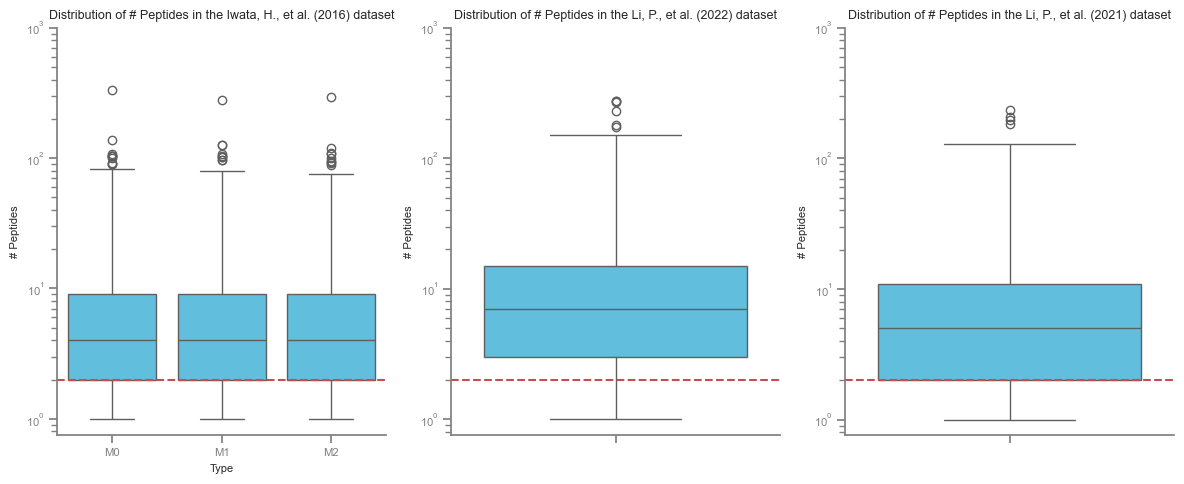

In [11]:
# Boxplot of the # Peptides for each dataset
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
sns.boxplot(data=df_2016_iwata, x="Type", y="# Peptides", ax=ax[0], log_scale=True)
sns.boxplot(data=df_2022_pengfei, y="# Peptides", ax=ax[1], log_scale=True)
sns.boxplot(data=df_2021_pengfei, y="# Peptides", ax=ax[2], log_scale=True)
ax[0].set_title("Distribution of # Peptides in the Iwata, H., et al. (2016) dataset")
ax[1].set_title("Distribution of # Peptides in the Li, P., et al. (2022) dataset")
ax[2].set_title("Distribution of # Peptides in the Li, P., et al. (2021) dataset")

for a in ax:
    a.axhline(y=MIN_NUM_PEPTIDE_THRESHOLD, color='r', linestyle='--')
    a.set_ylim([0, 1000])
    
plt.tight_layout()
plt.show()



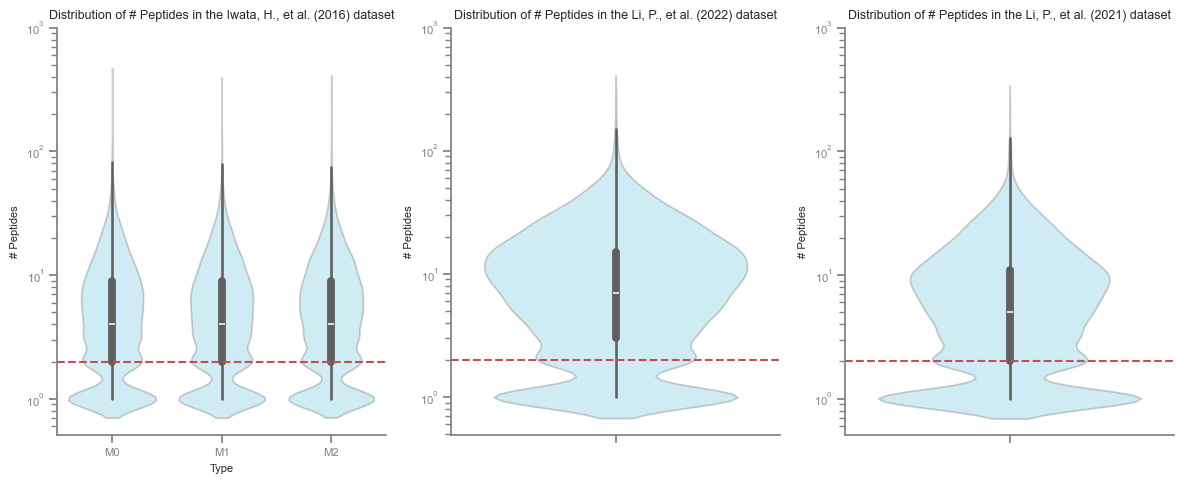

In [12]:
# same with violin plots
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
sns.violinplot(data=df_2016_iwata, x="Type", y="# Peptides", ax=ax[0], log_scale=True, alpha=0.3)
sns.violinplot(data=df_2022_pengfei, y="# Peptides", ax=ax[1], log_scale=True, alpha=0.3)
sns.violinplot(data=df_2021_pengfei, y="# Peptides", ax=ax[2], log_scale=True, alpha=0.3)
ax[0].set_title("Distribution of # Peptides in the Iwata, H., et al. (2016) dataset")
ax[1].set_title("Distribution of # Peptides in the Li, P., et al. (2022) dataset")
ax[2].set_title("Distribution of # Peptides in the Li, P., et al. (2021) dataset")
# Add a horizontal line at the threshold
for a in ax:
    a.axhline(y=MIN_NUM_PEPTIDE_THRESHOLD, color='r', linestyle='--')
    a.set_ylim([0, 1000])

plt.tight_layout()
plt.show()



Figure x. Distribution of Peptides in the three different datasets usign logaritmic scale. The red dashed line denotes a reference threshold across all plots

In [13]:
print(f"Percentage of proteins with less than {MIN_NUM_PEPTIDE_THRESHOLD} peptides:")

pct_iwata = (df_2016_iwata["# Peptides"] < MIN_NUM_PEPTIDE_THRESHOLD).sum() / df_2016_iwata.shape[0] * 100
print(f"  Iwata, H., et al. (2016): {pct_iwata:.2f}%")
pct_pengfei = (df_2022_pengfei["# Peptides"] < MIN_NUM_PEPTIDE_THRESHOLD).sum() / df_2022_pengfei.shape[0] * 100
print(f"  Li, P., et al. (2022): {pct_pengfei:.2f}%")
pct_pengfei = (df_2021_pengfei["# Peptides"] < MIN_NUM_PEPTIDE_THRESHOLD).sum() / df_2021_pengfei.shape[0] * 100
print(f"  Li, P., et al. (2021): {pct_pengfei:.2f}%")

Percentage of proteins with less than 2 peptides:
  Iwata, H., et al. (2016): 20.85%
  Li, P., et al. (2022): 15.42%
  Li, P., et al. (2021): 20.70%


In [14]:
print(df_2016_iwata.describe())
print(df_2022_pengfei.describe())
print(df_2021_pengfei.describe())
print(df_huffman_adata)

              Score      Coverage    # Proteins  # Unique Peptides  \
count  19247.000000  19247.000000  19247.000000       19247.000000   
mean      57.958304     19.276302      4.564919           6.064322   
std      140.107779     16.891390      4.696807           8.228747   
min        0.000000      0.050000      1.000000           0.000000   
25%        5.487738      6.200000      2.000000           2.000000   
50%       18.139427     14.090000      3.000000           4.000000   
75%       56.796837     27.740000      6.000000           8.000000   
max     3747.075588     95.900000    152.000000         327.000000   

         # Peptides        # PSMs  126/126  126/126 Count  \
count  19247.000000  19247.000000  19201.0   19201.000000   
mean       6.859355     22.705720      1.0      17.666892   
std        9.116540     54.949409      0.0      38.584949   
min        1.000000      1.000000      1.0       1.000000   
25%        2.000000      2.000000      1.0       2.000000   
50%

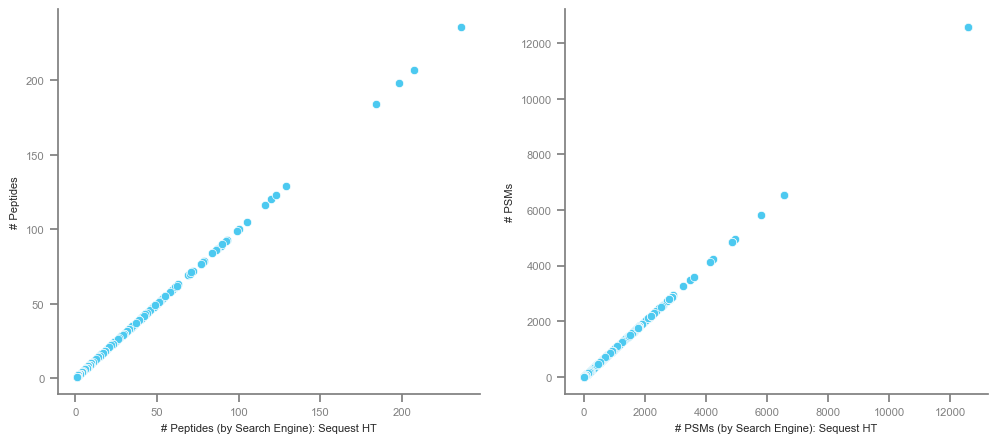

In [15]:
# Correlation plots of similar (duplicate) columns
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(data=df_2021_pengfei, x="# Peptides (by Search Engine): Sequest HT", y="# Peptides", ax=ax[0])
sns.scatterplot(data=df_2021_pengfei, x="# PSMs (by Search Engine): Sequest HT", y="# PSMs", ax=ax[1])
plt.show()



**Assumption:** The dataset Iwata, H., et al. (2016) has a column named "Score", while the other two bulk datasets have a column named "Score Sequest HT: Sequest HT".
<br>
According to the Proteome Discoverer Manual, I assume that the column "Score" in the Iwata, H., et al. (2016) dataset is equivalent to the Sequest Score in the other datasets.
<br><br>
For both columns, the formula used to compute the Score is:<br>
> &#160;<br>
> *protein_score = (sum_of_all_cross-correlation_factors_of_0.8_or_above) + (peptide_charge × peptide_relevance_factor)*
> <br>&#160;<br>

**Source**: *Proteome Discoverer Manual v2.2 (page 24)* 

---
### Filtering data

Low quality data must be filtered before the data analysis

Criteria:
* (Iwata 2016, Pengfei 2022 and Pengfei 2021 only):  The number of Peptide Spectrum Matches < 5. It represents the number of times a peptide sequence has been identified in the mass spectra. 
* (Iwata 2016 only): Protein not found in the initial time point.



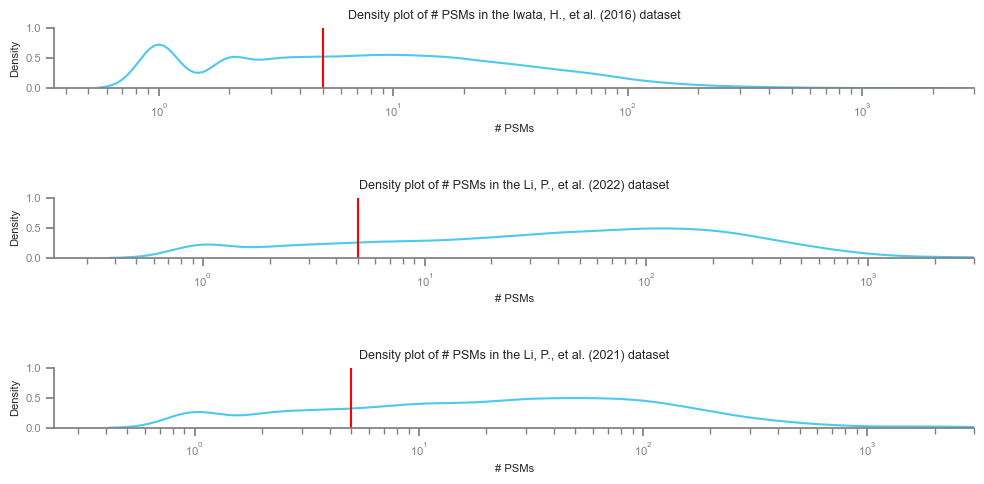

In [16]:
# Grid of density plots for the # PSMs for the first 3 experiments (use log scale)
fig, ax = plt.subplots(3, 1, figsize=(10, 5))
sns.kdeplot(df_2016_iwata["# PSMs"], log_scale=True, ax=ax[0])
sns.kdeplot(df_2022_pengfei["# PSMs"], log_scale=True, ax=ax[1])
sns.kdeplot(df_2021_pengfei["# PSMs"], log_scale=True, ax=ax[2])
ax[0].axvline(5, color='red')
ax[1].axvline(5, color='red')
ax[2].axvline(5, color='red')
ax[0].set_title("Density plot of # PSMs in the Iwata, H., et al. (2016) dataset")
ax[1].set_title("\n\nDensity plot of # PSMs in the Li, P., et al. (2022) dataset")
ax[2].set_title("\n\nDensity plot of # PSMs in the Li, P., et al. (2021) dataset")

for a in ax:
    a.set_xlim([0, 3000])
    a.set_ylim([0, 1])

plt.tight_layout()
plt.show()


Figure x. Distribution of Peptide-Spectrum Matches (PSMs). Comparative analysis of PSM distributions with the defined threshold represented with a red line. It shows the characteristics and quality of the datasets

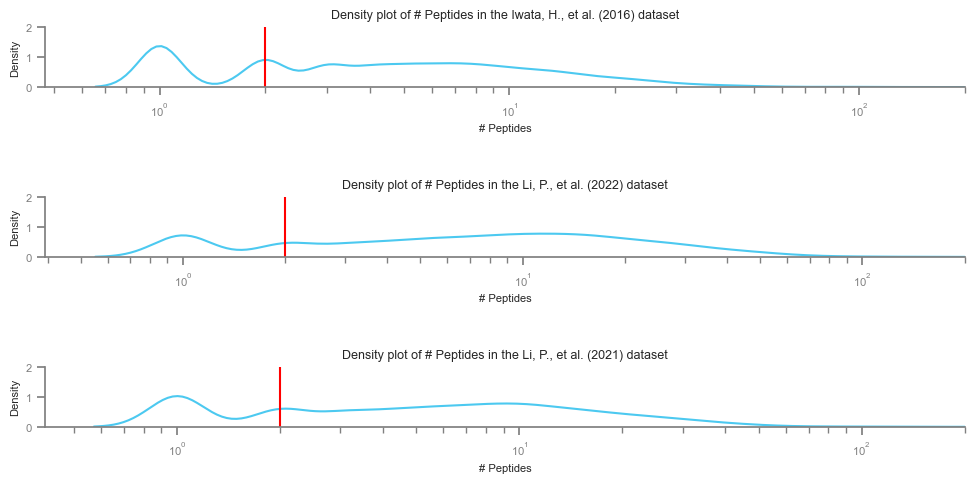

In [17]:
fig, ax = plt.subplots(3, 1, figsize=(10, 5))
sns.kdeplot(df_2016_iwata["# Peptides"], log_scale=True, ax=ax[0])
sns.kdeplot(df_2022_pengfei["# Peptides"], log_scale=True, ax=ax[1])
sns.kdeplot(df_2021_pengfei["# Peptides"], log_scale=True, ax=ax[2])
ax[0].axvline(MIN_NUM_PEPTIDE_THRESHOLD, color='red')
ax[1].axvline(MIN_NUM_PEPTIDE_THRESHOLD, color='red')
ax[2].axvline(MIN_NUM_PEPTIDE_THRESHOLD, color='red')
ax[0].set_title("Density plot of # Peptides in the Iwata, H., et al. (2016) dataset")
ax[1].set_title("\n\nDensity plot of # Peptides in the Li, P., et al. (2022) dataset")
ax[2].set_title("\n\nDensity plot of # Peptides in the Li, P., et al. (2021) dataset")

for a in ax:
    a.set_xlim([0, 200])
    a.set_ylim([0, 2])

plt.tight_layout()
plt.show()


In [18]:
# Experiment 1: 2016 Iwata et al.
# Filter out records with blank values in the column "126/126" (which should contain 1.00)
print("-- Removing proteins from Iwata, H., et al. (2016) dataset with null values in the column ['126/126'] ----------")
print("  Proteins with null values:", df_2016_iwata["126/126"].isnull().sum())
print("  This proteins MUST be removed from the dataset as they should have 1.00")
df_2016_iwata = df_2016_iwata[~df_2016_iwata["126/126"].isnull()]

# Keep proteins that has PSMs >= 5 (ref: https://pmc.ncbi.nlm.nih.gov/articles/PMC9110321/#s3)
print("\n-- Removing proteins that have PSMs < 5 -------------------------------------------------------------------")
print("  Iwata, H., et al. (2016):", df_2016_iwata[df_2016_iwata["# PSMs"] < PSM_THRESHOLD].shape[0], "out of",df_2016_iwata.shape[0], "proteins have been removed")
df_2016_iwata = df_2016_iwata[df_2016_iwata["# PSMs"] >= PSM_THRESHOLD]
print("  Li, P., et al. (2022):", df_2022_pengfei[df_2022_pengfei["# PSMs"] < PSM_THRESHOLD].shape[0], "out of",df_2022_pengfei.shape[0], "proteins have been removed")
df_2022_pengfei = df_2022_pengfei[df_2022_pengfei["# PSMs"] >= PSM_THRESHOLD]
print("  Li, P., et al. (2021):", df_2021_pengfei[df_2021_pengfei["# PSMs"] < PSM_THRESHOLD].shape[0], "out of",df_2021_pengfei.shape[0], "proteins have been removed")
df_2021_pengfei = df_2021_pengfei[df_2021_pengfei["# PSMs"] >= PSM_THRESHOLD]

# Filter by the number of peptides
print("\n-- Removing proteins that have less than 2 peptides --------------------------------------------------------")
print("  Iwata, H., et al. (2016):", df_2016_iwata[df_2016_iwata["# Peptides"] < MIN_NUM_PEPTIDE_THRESHOLD].shape[0], "out of",df_2016_iwata.shape[0], "proteins have been removed")
df_2016_iwata = df_2016_iwata[df_2016_iwata["# Peptides"] >= MIN_NUM_PEPTIDE_THRESHOLD]
print("  Li, P., et al. (2022):", df_2022_pengfei[df_2022_pengfei["# Peptides"] < MIN_NUM_PEPTIDE_THRESHOLD].shape[0], "out of",df_2022_pengfei.shape[0], "proteins have been removed")
df_2022_pengfei = df_2022_pengfei[df_2022_pengfei["# Peptides"] >= MIN_NUM_PEPTIDE_THRESHOLD]
print("  Li, P., et al. (2021):", df_2021_pengfei[df_2021_pengfei["# Peptides"] < MIN_NUM_PEPTIDE_THRESHOLD].shape[0], "out of",df_2021_pengfei.shape[0], "proteins have been removed")
df_2021_pengfei = df_2021_pengfei[df_2021_pengfei["# Peptides"] >= MIN_NUM_PEPTIDE_THRESHOLD]

# Filter by Score
print("\n-- Removing proteins with a score of > 1.5 ------------------------------------------------------------------")
print("  Iwata, H., et al. (2016):", df_2016_iwata[df_2016_iwata["Score"] < SCORE_THRESHOLD].shape[0], "out of",df_2016_iwata.shape[0], "proteins have been removed")
df_2016_iwata = df_2016_iwata[df_2016_iwata["Score"] >= SCORE_THRESHOLD]
print("  Li, P., et al. (2022):", df_2022_pengfei[df_2022_pengfei["Score Sequest HT: Sequest HT"] < SCORE_THRESHOLD].shape[0], "out of",df_2022_pengfei.shape[0], "proteins have been removed")
df_2022_pengfei = df_2022_pengfei[df_2022_pengfei["Score Sequest HT: Sequest HT"] >= SCORE_THRESHOLD]
print("  Li, P., et al. (2021):", df_2021_pengfei[df_2021_pengfei["Score Sequest HT: Sequest HT"] < SCORE_THRESHOLD].shape[0], "out of",df_2021_pengfei.shape[0], "proteins have been removed")
df_2021_pengfei = df_2021_pengfei[df_2021_pengfei["Score Sequest HT: Sequest HT"] >= SCORE_THRESHOLD]


# Print the number of proteins after filtering
print("\n-- Number of proteins after filtering -----------------------------------------------------------------------")
print("  Iwata, H., et al. (2016):", df_2016_iwata.index.nunique())
print("  Li, P., et al. (2022):", df_2022_pengfei.index.nunique())
print("  Li, P., et al. (2021):", df_2021_pengfei.index.nunique())


-- Removing proteins from Iwata, H., et al. (2016) dataset with null values in the column ['126/126'] ----------
  Proteins with null values: 46
  This proteins MUST be removed from the dataset as they should have 1.00

-- Removing proteins that have PSMs < 5 -------------------------------------------------------------------
  Iwata, H., et al. (2016): 7379 out of 19201 proteins have been removed
  Li, P., et al. (2022): 1146 out of 6616 proteins have been removed
  Li, P., et al. (2021): 1541 out of 7349 proteins have been removed

-- Removing proteins that have less than 2 peptides --------------------------------------------------------
  Iwata, H., et al. (2016): 108 out of 11822 proteins have been removed
  Li, P., et al. (2022): 213 out of 5470 proteins have been removed
  Li, P., et al. (2021): 369 out of 5808 proteins have been removed

-- Removing proteins with a score of > 1.5 ------------------------------------------------------------------
  Iwata, H., et al. (2016): 2 ou

---
### Translating protein accessions to Gene Names

UniProtKB REST API examples for a valid ID:
* [UniProtKB call using "P04075"](https://rest.uniprot.org/uniprotkb/P04075)
<br><br>

UniProtKB REST API examples for an old ID:
* [UniProtKB call using "F5H6Z3"](https://rest.uniprot.org/uniprotkb/F5H6Z3.json)
* [Unisave call using "F5H6Z3"](https://rest.uniprot.org/unisave/F5H6Z3?format=txt)
* [Uniparc call using UPI format "UPI00020656CD"](https://rest.uniprot.org/uniparc/UPI00020656CD)



In [19]:
if TRANSLATE_PROTEIN_ID:
    print("Translating protein IDs to gene names (Iwata, H., et al. (2016))... ")
    gene_names = uniprot.batch_translate_protein_ids(df_2016_iwata.index)
    df_2016_iwata['Gene'] = gene_names
    # save the df_2016_iwata to a file
    df_2016_iwata.to_csv("./data/processed/uniprot_out/df_2016_iwata.csv")

    print("Translating protein IDs to gene names (Li, P., et al. (2022))... ")
    gene_names = uniprot.batch_translate_protein_ids(df_2022_pengfei.index)
    df_2022_pengfei['Gene'] = gene_names
    # save the df_2022_pengfei to a file
    df_2022_pengfei.to_csv("./data/processed/uniprot_out/df_2022_pengfei.csv")

    print("Translating protein IDs to gene names (Li, P., et al. (2021))... ")
    gene_names = uniprot.batch_translate_protein_ids(df_2021_pengfei.index)
    df_2021_pengfei['Gene'] = gene_names
    # save the df_2021_pengfei to a file
    df_2021_pengfei.to_csv("./data/processed/uniprot_out/df_2021_pengfei.csv")
                           

    print("Translating protein IDs to gene names (Huffman, R. G., et al. (2022))... ")
    gene_names = uniprot.batch_translate_protein_ids(df_huffman_adata.var.index)
    df_huffman_adata.var['Gene'] = gene_names
    # save the df_huffman_adata to a file
    df_huffman_adata.write("./data/processed/uniprot_out/df_huffman_adata.h5ad")

else:
    # Load from files
    df_2016_iwata = pd.read_csv("./data/processed/uniprot_out/df_2016_iwata.csv", index_col=0)
    df_2022_pengfei = pd.read_csv("./data/processed/uniprot_out/df_2022_pengfei.csv", index_col=0)
    df_2021_pengfei = pd.read_csv("./data/processed/uniprot_out/df_2021_pengfei.csv", index_col=0)
    df_huffman_adata = ad.read_h5ad("./data/processed/uniprot_out/df_huffman_adata.h5ad")
    


In [20]:
# print top genes for df_2016_iwata
print(f"\n-- Top {TOP_GENES} genes in Iwata, H., et al. (2016) dataset --------------------------------------------------------------")
print(df_2016_iwata["Gene"].value_counts().head(TOP_GENES))

# print top genes for df_2022_pengfei
print(f"\n-- Top {TOP_GENES} genes in Li, P., et al. (2022) dataset -------------------------------------------------------------")
print(df_2022_pengfei["Gene"].value_counts().head(TOP_GENES))

# print top genes for df_2021_pengfei
print(f"\n-- Top {TOP_GENES} genes in Li, P., et al. (2021) dataset -------------------------------------------------------------")
print(df_2021_pengfei["Gene"].value_counts().head(TOP_GENES))

# print top genes for df_huffman_adata sorted by most counts
print(f"\n-- Top {TOP_GENES} genes in Huffman, R. G., et al. (2022) dataset -------------------------------------------------------------")
print(df_huffman_adata.var["Gene"].value_counts().head(TOP_GENES))


-- Top 25 genes in Iwata, H., et al. (2016) dataset --------------------------------------------------------------
Gene
EIF4G2      9
PPP1R12A    7
PPP1CB      7
TMPO        7
MBNL1       6
USP15       6
SPAG9       6
AAK1        6
LYPLAL1     6
PEX19       6
LYN         6
SKP1        6
CALU        6
KTN1        6
CAP1        6
GSN         6
PCBP2       6
PPFIBP1     6
HBA1        6
CNBP        6
DNM1L       6
GLYR1       6
CAMK2D      6
NAA50       6
VAPA        6
Name: count, dtype: int64

-- Top 25 genes in Li, P., et al. (2022) dataset -------------------------------------------------------------
Gene
HLA-C       2
HLA-B       2
AAK1        2
HLA-A       2
HLA-DRB1    2
TMPO        2
DYNC1H1     1
F13A1       1
MYDGF       1
INTS5       1
MAPK9       1
TRIM22      1
HGH1        1
ARID3A      1
NUBP1       1
ELOA        1
IWS1        1
NIP7        1
ACBD5       1
ZNF281      1
ITSN2       1
COG7        1
TIMM9       1
S100A8      1
NISCH       1
Name: count, dtype: int64

-- Top 25

Only few of the Genes with higher number of isoforms can be found in more than one dataset. And even in the case of being in more than one datasets, the number of appearances is very different.

In [21]:
# Upper case the gene names for Huffman, R. G., et al. (2022)
df_huffman_adata.var["Gene"] = df_huffman_adata.var["Gene"].str.upper()

In [22]:
# Intersection of the top genes by the number of "Isoforms"

print("\n-- Intersection of top genes (by count(gene)) in each dataset ----------------------------------------------------------------") 
top_genes_iwata = set(df_2016_iwata["Gene"].value_counts().head(TOP_GENES).index)
top_genes_pengfei = set(df_2022_pengfei["Gene"].value_counts().head(TOP_GENES).index)
top_genes_pengfei2 = set(df_2021_pengfei["Gene"].value_counts().head(TOP_GENES).index)
top_genes_huffman = set(df_huffman_adata.var["Gene"].value_counts().head(TOP_GENES).index)

print(" The genes found in the TOP of all 4 datasets are:", top_genes_iwata & top_genes_pengfei & top_genes_pengfei2 & top_genes_huffman)
print(" The genes found in the TOP of the 3 bulk datasets are:", top_genes_iwata & top_genes_pengfei & top_genes_pengfei2)
print(" The genes found in the TOP of the 2 bulk datasets from the same author are:", top_genes_pengfei & top_genes_pengfei2)
# Single-cell data was excluded due to all the genes were found only once.


-- Intersection of top genes (by count(gene)) in each dataset ----------------------------------------------------------------
 The genes found in the TOP of all 4 datasets are: set()
 The genes found in the TOP of the 3 bulk datasets are: {'TMPO', 'AAK1'}
 The genes found in the TOP of the 2 bulk datasets from the same author are: {'HLA-C', 'AAK1', 'TMPO', 'HLA-DRB1', 'HLA-B', 'HLA-A'}


Given that relying on isoforms may not effectively highlight "shared" proteins across all datasets, I will conduct the same analysis focusing on protein abundance. This approach is expected to yield a higher number of common proteins, as different proteomic studies are likely to identify and quantify similar highly abundant proteins. 

In [23]:

# Shared (considering Abundance)
print(f"\n-- Top {TOP_GENES} genes in Iwata, H., et al. (2016) dataset by Abundance --------------------------------------------------")
top_genes_2016_iwata_M0 = df_2016_iwata[df_2016_iwata["Type"] == "M0"][["Gene", "131/126"]].dropna().sort_values(by="131/126", ascending=False).head(TOP_GENES)
top_genes_2016_iwata_M1 = df_2016_iwata[df_2016_iwata["Type"] == "M1"][["Gene", "131/126"]].dropna().sort_values(by="131/126", ascending=False).head(TOP_GENES)
top_genes_2016_iwata_M2 = df_2016_iwata[df_2016_iwata["Type"] == "M2"][["Gene", "131/126"]].dropna().sort_values(by="131/126", ascending=False).head(TOP_GENES)

top_genes_2021_pengfei_M0 = df_2021_pengfei[["Gene", "Abundances (Grouped): M0"]].dropna().sort_values(by="Abundances (Grouped): M0", ascending=False).head(TOP_GENES)
top_genes_2021_pengfei_M1 = df_2021_pengfei[["Gene", "Abundances (Grouped): M1"]].dropna().sort_values(by="Abundances (Grouped): M1", ascending=False).head(TOP_GENES)
top_genes_2021_pengfei_M2 = df_2021_pengfei[["Gene", "Abundances (Grouped): M2"]].dropna().sort_values(by="Abundances (Grouped): M2", ascending=False).head(TOP_GENES)

top_genes_2022_pengfei_M0 = df_2022_pengfei[["Gene", "Abundances (Grouped): M0"]].dropna().sort_values(by="Abundances (Grouped): M0", ascending=False).head(TOP_GENES)
top_genes_2022_pengfei_M1 = df_2022_pengfei[["Gene", "Abundances (Grouped): M1"]].dropna().sort_values(by="Abundances (Grouped): M1", ascending=False).head(TOP_GENES)
top_genes_2022_pengfei_M2 = df_2022_pengfei[["Gene", "Abundances (Grouped): M2"]].dropna().sort_values(by="Abundances (Grouped): M2", ascending=False).head(TOP_GENES)

print("  Iwata, H., et al. (2016) M0")
print(top_genes_2016_iwata_M0)
print("  Li, P., et al. (2022) M0")
print(top_genes_2022_pengfei_M0)
print("  Li, P., et al. (2021) M0")
print(top_genes_2021_pengfei_M0)

print("  Iwata, H., et al. (2016) M1")
print(top_genes_2016_iwata_M1)
print("  Li, P., et al. (2022) M1")
print(top_genes_2022_pengfei_M1)
print("  Li, P., et al. (2021) M1")
print(top_genes_2021_pengfei_M1)

print("  Iwata, H., et al. (2016) M2")
print(top_genes_2016_iwata_M2)
print("  Li, P., et al. (2022) M2")
print(top_genes_2022_pengfei_M2)
print("  Li, P., et al. (2021) M2")
print(top_genes_2021_pengfei_M2)



-- Top 25 genes in Iwata, H., et al. (2016) dataset by Abundance --------------------------------------------------
  Iwata, H., et al. (2016) M0
              Gene   131/126
Accession                   
P17252       PRKCA  3.085788
Q8TBN0     RAB3IL1  2.730899
F5H5M7      IFNGR1  2.535574
P04004         VTN  2.457770
F5H2M9        GBP1  2.442830
H0Y3Z3        P4HB  2.324600
P02765        AHSG  2.294278
Q92674       CENPI  2.282612
P06493-2      CDK1  2.194743
Q16695        H3-4  2.185531
Q8NI35-5      PATJ  2.150211
P53674      CRYBB1  2.149782
E9PD90       CKAP2  2.124382
B7ZKQ9      SCARB1  2.063658
Q16352         INA  2.029002
C9JKR2         ALB  2.028277
F5H4V4       MKI67  2.012904
P11388       TOP2A  2.010637
Q9NQW6        ANLN  2.002610
P07951        TPM2  1.980914
Q9Y6A5       TACC3  1.938522
Q14980       NUMA1  1.905354
P02774          GC  1.890009
P55899       FCGRT  1.887750
Q96D96-2     HVCN1  1.882268
  Li, P., et al. (2022) M0
              Gene  Abundances (Grouped): M

In [24]:
# Shared genes in the top abundant genes by group 

# M0
print("Genes present in the top", TOP_GENES, "genes in M0 for all datasets:")
print("  Iwata, H., et al. (2016):", top_genes_2016_iwata_M0["Gene"].values)
print("  Li, P., et al. (2022):", top_genes_2022_pengfei_M0["Gene"].values)
print("  Li, P., et al. (2021):", top_genes_2021_pengfei_M0["Gene"].values)

intersection_genes = set(top_genes_2016_iwata_M0["Gene"]).intersection(
    set(top_genes_2022_pengfei_M0["Gene"]),
    set(top_genes_2021_pengfei_M0["Gene"])
)
print("Intersection of top genes in M0 the three bulk all datasets:", list(intersection_genes))

# M1
print("\nGenes present in the top", TOP_GENES, "genes in M1 for all datasets:")
print("  Iwata, H., et al. (2016):", top_genes_2016_iwata_M1["Gene"].values)
print("  Li, P., et al. (2022):", top_genes_2022_pengfei_M1["Gene"].values)
print("  Li, P., et al. (2021):", top_genes_2021_pengfei_M1["Gene"].values)

intersection_genes = set(top_genes_2016_iwata_M1["Gene"]).intersection(
    set(top_genes_2022_pengfei_M1["Gene"]),
    set(top_genes_2021_pengfei_M1["Gene"])
)
print("Intersection of top genes in M1 for the three bulk datasets:", list(intersection_genes))

# M2
print("\nGenes present in the top", TOP_GENES, "genes in M2 for all datasets:")
print("  Iwata, H., et al. (2016):", top_genes_2016_iwata_M2["Gene"].values)
print("  Li, P., et al. (2022):", top_genes_2022_pengfei_M2["Gene"].values)
print("  Li, P., et al. (2021):", top_genes_2021_pengfei_M2["Gene"].values)

intersection_genes = set(top_genes_2016_iwata_M2["Gene"]).intersection(
    set(top_genes_2022_pengfei_M2["Gene"]),
    set(top_genes_2021_pengfei_M2["Gene"])
)
print("Intersection of top genes in M2 for the three bulk datasets:", list(intersection_genes))


Genes present in the top 25 genes in M0 for all datasets:
  Iwata, H., et al. (2016): ['PRKCA' 'RAB3IL1' 'IFNGR1' 'VTN' 'GBP1' 'P4HB' 'AHSG' 'CENPI' 'CDK1'
 'H3-4' 'PATJ' 'CRYBB1' 'CKAP2' 'SCARB1' 'INA' 'ALB' 'MKI67' 'TOP2A'
 'ANLN' 'TPM2' 'TACC3' 'NUMA1' 'GC' 'FCGRT' 'HVCN1']
  Li, P., et al. (2022): ['ZFAND1' 'MRPL52' 'UBASH3B' 'DENND4A' 'PRKAR2B' 'WDHD1' 'POU2F1' 'GINS3'
 'FLT3' 'TGFBR1' 'CCDC51' 'APOC1' 'LYZ' 'PZP' 'CTDSPL2' 'ITM2B' 'MLX'
 'PPCDC' 'UBP1' 'PRTN3' 'STAU2' 'ACTR3B' 'RFC1' 'BST2' 'WIZ']
  Li, P., et al. (2021): ['CCDC25' 'TACC3' 'ZNF830' 'EGFL7' 'MTF2' 'CNN3' 'KNTC1' 'RREB1' 'NSD3'
 'YJU2' 'MSL1' 'CIP2A' 'RRP15' 'BMI1' 'PIAS1' 'WAC' 'KIF2C' 'ANAPC5'
 'ASF1B' 'TMOD1' 'E2F4' 'MPLKIP' 'ZNF148' 'PFKFB3' 'NCAPG2']
Intersection of top genes in M0 the three bulk all datasets: []

Genes present in the top 25 genes in M1 for all datasets:
  Iwata, H., et al. (2016): ['IDO1' 'HLA-DRA' 'GBP1' 'HLA-DQA1' 'ANKRD22' 'SPP1' 'H2BC18' 'WARS1'
 'ALB' 'PINLYP' 'HSPA2' 'GBP5' 'MYL12A' 'RP

None of the most abundant Genes (by group) are found in the three bulk datasets.

In [25]:
# Save the data into 4 files
#df_2016_iwata.to_csv("./data/processed/2016_iwata_genes.csv")
#df_2022_pengfei.to_csv("./data/processed/2022_pengfei_genes.csv")
#df_2021_pengfei.to_csv("./data/processed/2021_pengfei_genes.csv")
#df_huffman_adata.write("./data/processed/2022_huffman_genes.h5ad")

In [26]:
# Remove null values 
print("\nRemoving Null values for Gene Name")
print("  Iwata, H., et al. (2016):", df_2016_iwata["Gene"].isnull().sum().sum())
print("  Li, P., et al. (2022):", df_2022_pengfei["Gene"].isnull().sum().sum())
print("  Li, P., et al. (2021):", df_2021_pengfei["Gene"].isnull().sum().sum())
print("  Huffman, R. G., et al. (2022):", df_huffman_adata.var[df_huffman_adata.var["Gene"].isnull()].shape[0])

df_2016_iwata = df_2016_iwata[~df_2016_iwata["Gene"].isnull()]
df_2022_pengfei = df_2022_pengfei[~df_2022_pengfei["Gene"].isnull()]
df_2021_pengfei = df_2021_pengfei[~df_2021_pengfei["Gene"].isnull()]
df_huffman_adata = df_huffman_adata[:, ~df_huffman_adata.var["Gene"].isnull()]



Removing Null values for Gene Name
  Iwata, H., et al. (2016): 53
  Li, P., et al. (2022): 1
  Li, P., et al. (2021): 1
  Huffman, R. G., et al. (2022): 18


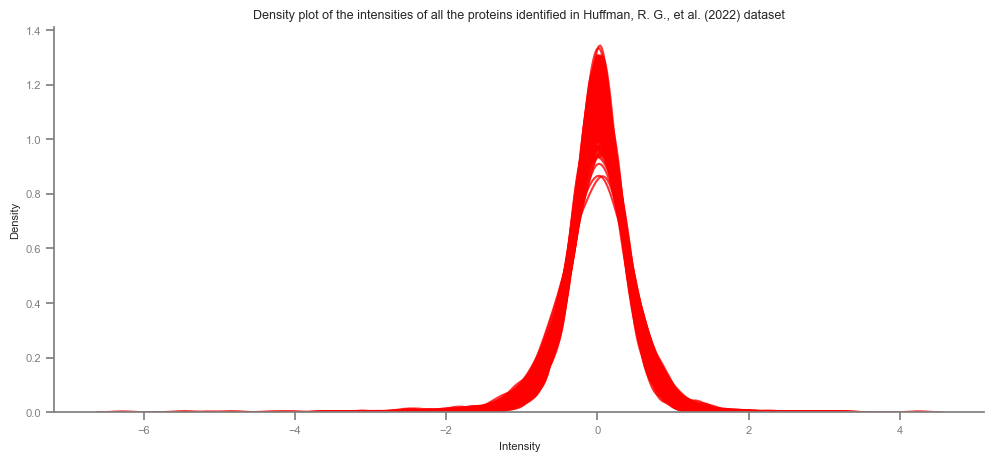

In [49]:
# Density plot for the intensities of all the proteins identified in Huffman, R. G., et al. (2022) dataset
df_huffman_intensity = pd.DataFrame(df_huffman_adata.X, index=df_huffman_adata.obs.index, columns=df_huffman_adata.var.index)
df_huffman_intensity = df_huffman_intensity.T

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
for col in df_huffman_intensity.columns:
    sns.kdeplot(df_huffman_intensity[col], ax=ax, color='red', alpha=0.8)
ax.set_title("Density plot of the intensities of all the proteins identified in Huffman, R. G., et al. (2022) dataset")
ax.set_xlabel("Intensity")
plt.show()


-- Checking missing values and outliers -----------------------------------------
  Iwata, H., et al. (2016): 1680
  Li, P., et al. (2022): 17555
  Li, P., et al. (2021): 37778
  Huffman, R. G., et al. (2022): 0


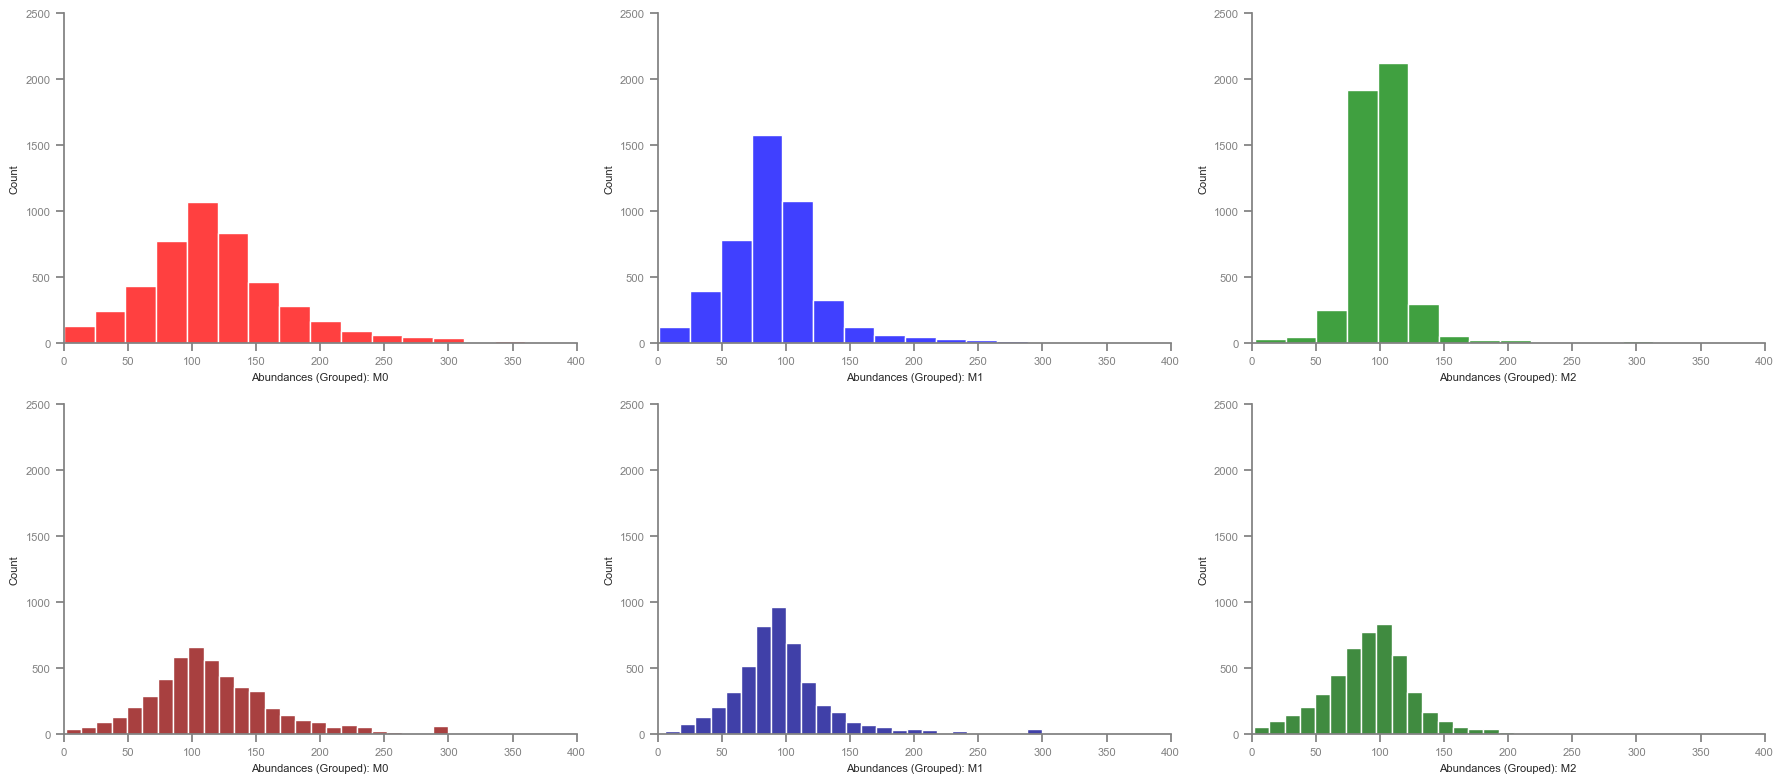


Number of proteins with Abundance higher than 500:
  Li, P., et al. (2022) M0: 14
  Li, P., et al. (2022) M1: 22

Max and min values for the abundance:
  Li, P., et al. (2022) M0,  Min: 0.1  - Max:  600.0
  Li, P., et al. (2022) M1,  Min: 1.3  - Max:  600.0
  Li, P., et al. (2022) M2,  Min: 2.525  - Max:  600.0

  Li, P., et al. (2021) M0,  Min: 1.6  - Max:  300.0
  Li, P., et al. (2021) M1,  Min: 5.9  - Max:  300.0
  Li, P., et al. (2021) M2,  Min: 1.7  - Max:  300.0


In [105]:
# Check missing values and outliers for df_2016_iwata
print("\n-- Checking missing values and outliers -----------------------------------------")
print("  Iwata, H., et al. (2016):", df_2016_iwata.isnull().sum().sum())
print("  Li, P., et al. (2022):", df_2022_pengfei.isnull().sum().sum())
print("  Li, P., et al. (2021):", df_2021_pengfei.isnull().sum().sum())
print("  Huffman, R. G., et al. (2022):", np.isnan(df_huffman_adata.X).sum())

# Check the distribution of the intensities for the 4 datasets
fig, ax = plt.subplots(2, 3, figsize=(18, 8))
sns.histplot(df_2022_pengfei["Abundances (Grouped): M0"], log_scale=False, ax=ax[0,0], legend=False, bins=25, color="red")
sns.histplot(df_2021_pengfei["Abundances (Grouped): M0"], log_scale=False, ax=ax[1,0], legend=False, bins=25, color="darkred")
sns.histplot(df_2022_pengfei["Abundances (Grouped): M1"], log_scale=False, ax=ax[0,1], legend=False, bins=25, color="blue")
sns.histplot(df_2021_pengfei["Abundances (Grouped): M1"], log_scale=False, ax=ax[1,1], legend=False, bins=25, color="darkblue")
sns.histplot(df_2022_pengfei["Abundances (Grouped): M2"], log_scale=False, ax=ax[0,2], legend=False, bins=25, color="green")
sns.histplot(df_2021_pengfei["Abundances (Grouped): M2"], log_scale=False, ax=ax[1,2], legend=False, bins=25, color="darkgreen")

# for each column, put the same scale for the x-axis and the y-axis
for a in ax.flatten():
    a.set_xlim([0, 400])
    a.set_ylim([0, 2500])

plt.tight_layout()
plt.show()

# Set y-axis labels
ax[0,0].set_ylabel("Count of Proteins (Li, P., et al. (2022))")
ax[1,0].set_ylabel("Count of Proteins (Li, P., et al. (2021))")
ax[0,1].set_ylabel("Count of Proteins (Li, P., et al. (2022))")
ax[1,1].set_ylabel("Count of Proteins (Li, P., et al. (2021))")
ax[0,2].set_ylabel("Count of Proteins (Li, P., et al. (2022))")
ax[1,2].set_ylabel("Count of Proteins (Li, P., et al. (2021))")

# Number of counts with Abundance higher than 500
print("\nNumber of proteins with Abundance higher than 500:")
print("  Li, P., et al. (2022) M0:", (df_2022_pengfei["Abundances (Grouped): M0"] > 500).sum())
print("  Li, P., et al. (2022) M1:", (df_2022_pengfei["Abundances (Grouped): M1"] > 500).sum())

# Min and Max values
print("\nMax and min values for the abundance:")
print("  Li, P., et al. (2022) M0,  Min:", df_2022_pengfei["Abundances (Grouped): M0"].min(), " - Max: ",df_2022_pengfei["Abundances (Grouped): M0"].max())
print("  Li, P., et al. (2022) M1,  Min:", df_2022_pengfei["Abundances (Grouped): M1"].min(), " - Max: ",df_2022_pengfei["Abundances (Grouped): M1"].max())
print("  Li, P., et al. (2022) M2,  Min:", df_2022_pengfei["Abundances (Grouped): M2"].min(), " - Max: ",df_2022_pengfei["Abundances (Grouped): M2"].max())
print("\n  Li, P., et al. (2021) M0,  Min:", df_2021_pengfei["Abundances (Grouped): M0"].min(), " - Max: ",df_2021_pengfei["Abundances (Grouped): M0"].max())
print("  Li, P., et al. (2021) M1,  Min:", df_2021_pengfei["Abundances (Grouped): M1"].min(), " - Max: ",df_2021_pengfei["Abundances (Grouped): M1"].max())
print("  Li, P., et al. (2021) M2,  Min:", df_2021_pengfei["Abundances (Grouped): M2"].min(), " - Max: ",df_2021_pengfei["Abundances (Grouped): M2"].max())

In [ ]:
# Filter out the genes with gene name starting by 'None ('
print("\n-- Removing proteins without Gene Name ---------------------------------------------------------------------")
print("  Iwata, H., et al. (2016):", df_2016_iwata[df_2016_iwata["Gene"].str.startswith("None (")].shape[0], "out of",df_2016_iwata.shape[0], "proteins have been removed")
df_2016_iwata = df_2016_iwata[~df_2016_iwata["Gene"].str.startswith("None (")]
print("  Li, P., et al. (2022):", df_2022_pengfei[df_2022_pengfei["Gene"].str.startswith("None (")].shape[0], "out of",df_2022_pengfei.shape[0], "proteins have been removed")
df_2022_pengfei = df_2022_pengfei[~df_2022_pengfei["Gene"].str.startswith("None (")]
print("  Li, P., et al. (2021):", df_2021_pengfei[df_2021_pengfei["Gene"].str.startswith("None (")].shape[0], "out of",df_2021_pengfei.shape[0], "proteins have been removed")
df_2021_pengfei = df_2021_pengfei[~df_2021_pengfei["Gene"].str.startswith("None (")]
print("  Huffman, R. G., et al. (2022):", df_huffman_adata.var[df_huffman_adata.var["Gene"].str.startswith("None (")].shape[0], "out of",df_huffman_adata.shape[1], "proteins have been removed")
df_huffman_adata = df_huffman_adata[:, ~df_huffman_adata.var["Gene"].str.startswith("None (")]


print("\n-- Number of proteins after filtering -----------------------------------------------------------------------")
print("  Iwata, H., et al. (2016):", df_2016_iwata["Gene"].nunique())
print("  Li, P., et al. (2022):", df_2022_pengfei["Gene"].nunique())
print("  Li, P., et al. (2021):", df_2021_pengfei["Gene"].nunique())
print("  Huffman, R. G., et al. (2022):", df_huffman_adata.var["Gene"].nunique())

---
## 1. Quantitative proteomic profiling of M0, M1 and M2

**1.1 Total number of identified proteins per Dataset**

In [ ]:
df_studies = pd.DataFrame({
    "Study": ["Iwata, H., et al. (2016)", "Li, P., et al. (2022)", "Li, P., et al. (2021)", "Huffman, R. G., et al. (2022)"],
    "Unique Proteins": [len(df_2016_iwata["Gene"].unique()), len(df_2022_pengfei["Gene"].unique()), len(df_2021_pengfei["Gene"].unique()), len(df_huffman_adata.var["Gene"].unique())],
    "Study type": ["Bulk", "Bulk", "Bulk", "Single-cell"]
})

print("Total number of proteins identified in each dataset (includes proteins found in M0, M1 and M2):")
for i in range(len(df_studies)):
    print(df_studies["Study"][i], "->", df_studies["Unique Proteins"][i], "unique proteins")

plt.figure(figsize=(9, 5))
sns.barplot(data=df_studies, x="Study", y="Unique Proteins", hue="Study type")
plt.xticks(rotation=45)
plt.title("Number of unique proteins identified in each study (including M0, M1 and M2)")
plt.show()


Note that 2022 Huffman et al. do not contain data for M2 phenotype.

**Comparing the Genes instead of Proteins**

In [ ]:
# Number of genes found in each dataset
df_studies = pd.DataFrame({
    "Study": ["Iwata, H., et al. (2016)", "Li, P., et al. (2022)", "Li, P., et al. (2021)", "Huffman, R. G., et al. (2022)"],
    "Unique Genes": [len(df_2016_iwata["Gene"].unique()), len(df_2022_pengfei["Gene"].unique()), len(df_2021_pengfei["Gene"].unique()), len(df_huffman_adata.var["Gene"].unique())],
    "Study type": ["Bulk", "Bulk", "Bulk", "Single-cell"]
})

print("Total number of genes identified in each dataset (includes proteins found in M0, M1 and M2):")
for i in range(len(df_studies)):
    print(df_studies["Study"][i], "->", df_studies["Unique Genes"][i], "unique genes")


**1.2 Total number of identified proteins per Dataset and cell type**

In [ ]:
# Number of proteins found in each cell type (M0, M1 and M2)
print("Number of proteins found in each cell type:")
print ("\nIwata, H., et al. (2016)")
for cell_type in df_2016_iwata["Type"].unique():
    print(" ", cell_type, ":", len(df_2016_iwata[df_2016_iwata["Type"] == cell_type].index.unique()))

print ("\nLi, P., et al. (2022)")
print("  M0: ", len(df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M0"] > 0].index.unique()))
print("  M1: ", len(df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M1"] > 0].index.unique()))
print("  M2: ", len(df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M2"] > 0].index.unique()))

print ("\nLi, P., et al. (2021)")
print("  M0: ", len(df_2021_pengfei[df_2021_pengfei["Abundances (Grouped): M0"] > 0].index.unique()))
print("  M1: ", len(df_2021_pengfei[df_2021_pengfei["Abundances (Grouped): M1"] > 0].index.unique()))
print("  M2: ", len(df_2021_pengfei[df_2021_pengfei["Abundances (Grouped): M2"] > 0].index.unique()))

print ("\nHuffman, R. G., et al. (2022) - Not available due to data limitations")
print("  M0: N/A")
print("  M1: N/A")
print("  M2: N/A")



TODO: Review pSCoPE code (are they filtering missing values?)
In a single-cell pipeline, there is a tendency of applying "technical drop out"

**1.3 Quantifiable proteins among the different cell types**

In [ ]:
from matplotlib_venn import venn3

# Create the figure with subplots
fig, ax = plt.subplots(1, 3, figsize=(10, 4))

# Venn diagram for the first experiment
exp1_proteinsM0 = set(df_2016_iwata[df_2016_iwata["Type"] == "M0"].index)
exp1_proteinsM1 = set(df_2016_iwata[df_2016_iwata["Type"] == "M1"].index)
exp1_proteinsM2 = set(df_2016_iwata[df_2016_iwata["Type"] == "M2"].index)
venn1 = venn3([exp1_proteinsM0, exp1_proteinsM1, exp1_proteinsM2], 
              set_labels=('M0', 'M1', 'M2'), 
              set_colors=('mediumaquamarine', 'slategrey', 'gold'), 
              ax=ax[0])
ax[0].set_title("Proteins found by cell type\n(Iwata, H., et al. (2016))")

# Venn diagram for the second experiment
exp2_proteinsM0 = set(df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M0"] > 0].index)
exp2_proteinsM1 = set(df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M1"] > 0].index)
exp2_proteinsM2 = set(df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M2"] > 0].index)
venn2 = venn3([exp2_proteinsM0, exp2_proteinsM1, exp2_proteinsM2], 
              set_labels=('M0', 'M1', 'M2'), 
              set_colors=('mediumaquamarine', 'slategrey', 'gold'), 
              ax=ax[1])
ax[1].set_title("Proteins found by cell type\n(Li, P., et al. (2022))")

# Venn diagram for the third experiment
exp3_proteinsM0 = set(df_2021_pengfei[df_2021_pengfei["Abundances (Grouped): M0"] > 0].index)
exp3_proteinsM1 = set(df_2021_pengfei[df_2021_pengfei["Abundances (Grouped): M1"] > 0].index)
exp3_proteinsM2 = set(df_2021_pengfei[df_2021_pengfei["Abundances (Grouped): M2"] > 0].index)
venn3 = venn3([exp3_proteinsM0, exp3_proteinsM1, exp3_proteinsM2], 
              set_labels=('M0', 'M1', 'M2'), 
              set_colors=('mediumaquamarine', 'slategrey', 'gold'), 
              ax=ax[2])
ax[2].set_title("Proteins found by cell type\n(Li, P., et al. (2021))")


# Set the font size for the set labels and subset labels for all diagrams
for venn in [venn1, venn2, venn3]:
    for label in venn.set_labels:
        if label is not None:
            label.set_fontsize(9)

    for label in venn.subset_labels:
        if label is not None:
            label.set_fontsize(9)

plt.tight_layout()
plt.show()


*Note that some of the identified proteins might have a very low abundance. These diagrams consider all proteins found regardless of the abundance. 
<br>It also includes proteins found in just some of the samples of a specific cell type.*

<br>
<u>Due to limitations on the data available for Huffman et al. 2021, it is not possible to plot its Venn diagram</u>

**1.4 Proteins found in ALL datasets (excluding those without this information), grouped by cell type**<br><br>

First, considering only bulk data.

In [ ]:
from matplotlib_venn import venn3

commonM0_proteins = exp1_proteinsM0.intersection(exp2_proteinsM0).intersection(exp3_proteinsM0)
commonM1_proteins = exp1_proteinsM1.intersection(exp2_proteinsM1).intersection(exp3_proteinsM1)
commonM2_proteins = exp1_proteinsM2.intersection(exp2_proteinsM2).intersection(exp3_proteinsM2)

print("Number of common proteins found in M0:", len(commonM0_proteins))
print("Number of common proteins found in M1:", len(commonM1_proteins))
print("Number of common proteins found in M2:", len(commonM2_proteins))


# Venn diagram for the common proteins
venn = venn3([commonM0_proteins, commonM1_proteins, commonM2_proteins], set_labels=('M0', 'M1', 'M2'), set_colors=('mediumaquamarine', 'slategrey', 'gold'))
plt.title("Common proteins found by cell type")

for label in venn.set_labels:
    if label is not None:
        label.set_fontsize(9)

for label in venn.subset_labels:
    if label is not None:
        label.set_fontsize(9)
plt.show()


Now, data from single-cell is also included.

In [ ]:
exp4_proteins = set(df_huffman_adata.var.index)

# As it is not possible to know the proteins found in each cell type for the experiment 5, a conservative approach is taken so that no protein is excluded
huff_commonM0_proteins = exp1_proteinsM0.intersection(exp2_proteinsM0).intersection(exp3_proteinsM0).intersection(exp4_proteins)
huff_commonM1_proteins = exp1_proteinsM1.intersection(exp2_proteinsM1).intersection(exp3_proteinsM1).intersection(exp4_proteins)

# Print the number of common proteins
print("Number of common proteins found in M0:", len(huff_commonM0_proteins))
print("Number of common proteins found in M1:", len(huff_commonM1_proteins))

By intersecting the proteins identified in the single cell experiment (Huffman et al. 2022), **there is no coincidence** with any protein, neither in M0 nor in M1. 
Note that single-cell data do not contain M2 cell types.

The same exercise follows, but now **using the gene name instead of the protein ID**.

In [ ]:
common_genes = set(df_2016_iwata["Gene"]).intersection(set(df_2022_pengfei["Gene"])).intersection(set(df_2021_pengfei["Gene"])).intersection(set(df_huffman_adata.var["Gene"]))
print("Number of common genes found in all datasets:", len(common_genes))

As the result of intersecting the gene names, **936 genes** have been identified as common in the 4 datasets

Now gene names are used to analyse the distribution of proteins present in all the datasets by cell types

In [ ]:
exp1_genesM0 = df_2016_iwata[df_2016_iwata["Type"] == "M0"]["Gene"]
exp1_genesM1 = df_2016_iwata[df_2016_iwata["Type"] == "M1"]["Gene"]
exp1_genesM2 = df_2016_iwata[df_2016_iwata["Type"] == "M2"]["Gene"]

exp2_genesM0 = df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M0"] > 0]["Gene"]
exp2_genesM1 = df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M1"] > 0]["Gene"]
exp2_genesM2 = df_2022_pengfei[df_2022_pengfei["Abundances (Grouped): M2"] > 0]["Gene"]

exp3_genesM0 = df_2021_pengfei[df_2021_pengfei["Abundances (Grouped): M0"] > 0]["Gene"]
exp3_genesM1 = df_2021_pengfei[df_2021_pengfei["Abundances (Grouped): M1"] > 0]["Gene"]
exp3_genesM2 = df_2021_pengfei[df_2021_pengfei["Abundances (Grouped): M2"] > 0]["Gene"]

exp4_genes = df_huffman_adata.var["Gene"] 

In [ ]:
from matplotlib_venn import venn2

commonM0_genes = set(exp1_genesM0).intersection(set(exp2_genesM0)).intersection(set(exp3_genesM0)).intersection(set(exp4_genes))
commonM1_genes = set(exp1_genesM1).intersection(set(exp2_genesM1)).intersection(set(exp3_genesM1)).intersection(set(exp4_genes))

print("Number of common genes found in M0:", len(commonM0_genes))
print("Number of common genes found in M1:", len(commonM1_genes))
print("Note that M2 genes are not considered as they are not available for the Huffman, R. G., et al. (2022) dataset")

# Venn diagram for the common genes
venn = venn2([commonM0_genes, commonM1_genes], set_labels=('M0          ', '          M1'), set_colors=('mediumaquamarine', 'slategrey'))
plt.title("Number of genes found in all studies by cell type")

for label in venn.set_labels:
    if label is not None:
        label.set_fontsize(10)

for label in venn.subset_labels:
    if label is not None:
        label.set_fontsize(10)
plt.show()


As can be observed, there is a significant overlap in the genes expresssed across the four datasets.<br>
Only few genes are exclusively expresed in each of the two groups.<br>
This highlights the extensive commonality in protein expression between the different cell types.

**1.5 Comparing genes found in Bulk vs SC experiments**

The objective is now to compare the proteins identified in all bulk datasets with those found in all single-cell experiments.

In [ ]:
from matplotlib_venn import venn2

df_bulk = pd.concat([df_2016_iwata, df_2022_pengfei, df_2021_pengfei])
df_bulk_genes = df_bulk["Gene"].unique()
df_sc = df_huffman_adata.var["Gene"].unique()

df_bulk_genes = [x for x in df_bulk_genes if str(x) != 'nan']
df_sc = [x for x in df_sc if str(x) != 'nan']

venn = venn2([set(df_bulk_genes), set(df_sc)], set_labels=('Bulk', 'Single-cell'), set_colors=('slategrey', 'gold'))
plt.title("Genes found in Bulk vs Single-cell")


for label in venn.set_labels:
    if label is not None:
        label.set_fontsize(10)

for label in venn.subset_labels:
    if label is not None:
        label.set_fontsize(10)

plt.show()

In [ ]:
df_2016_iwata2 = df_2016_iwata.copy()
# Rename the column "Score" to "Score Sequest HT: Sequest HT"
df_2016_iwata2 = df_2016_iwata2.rename(columns={"Score": "Score Sequest HT: Sequest HT"})

# Merge df_2016_iwata, df_2022_pengfei and df_2021_pengfei
df_bulk = pd.concat([df_2016_iwata2, df_2022_pengfei, df_2021_pengfei])
df_bulk

# pritn unique accessions (index) for the bulk data
print("Unique accessions for the bulk data:", df_bulk.index.nunique())
print("Unique gene names for the bulk data:", df_bulk["Gene"].nunique())


As observed in the previous diagram, most proteins identified in single-cell experiments are also present in bulk samples. However, some proteins are exclusively detected in either bulk or single-cell experiments. Here are some reasons for these discrepancies:<br>
* **Sensitivity:** Bulk proteomics often offers higher sensitivity, enabling the identification of low-abundance proteins that single-cell proteomics (SCP) might miss due to the smaller sample size. However, SCP provides higher resolution, allowing the detection of rare proteins.

* **Number of cells included in experiments:** Bulk experiments analyze a large number of cells together, while SCP examines individual cells. This difference in population size can lead to variations in the detected proteins.

* **Heterogeneity:** SCP can identify proteins that are present only in specific cells within a population. In contrast, bulk experiments average the signal from many cells, potentially masking these proteins.

* **Post-Translational Modifications (PTMs):** SCP can capture PTMs that may be missed in bulk experiments, as these modifications might not be uniformly distributed across the entire cell population.

* **Technical variability:** The field of proteomics is rapidly evolving, with continuous improvements in methods and technologies. Variations in sample preparation and processing can significantly impact the final results, contributing to differences in protein identification between bulk and single-cell experiments.

The proteins found in single-cell datasets only:

In [ ]:
print("Genes found in single-cells only:", len(set(df_sc) - set(df_bulk_genes)))

only_sc = set(df_sc) - set(df_bulk_genes)
for gene in only_sc:
    print(gene)


When working with proteomics data, the method of data acquisition can significantly impact the proteins detected in the experiment. The three bulk datasets were acquired using Data-Dependent Acquisition (DDA), while the single-cell dataset was obtained through Data-Independent Acquisition (DIA).

The proteins found only in the single-cell dataset might be due to DIA's full scanning approach, which captures a wider spectrum of proteins compared to DDA's selective targeting.

In [ ]:
# Dictionaries with the protein IDs and gene names (for single-cell data)
sc_gene_dict = dict(zip(df_huffman_adata.var["Gene"], df_huffman_adata.var.index))
sc_prot_dict = dict(zip(df_huffman_adata.var.index, df_huffman_adata.var["Gene"]))

only_sc_genes = {k: sc_gene_dict[k] for k in only_sc}

## 2. Up/Down-represented Proteins

### 2.0 Data preparation

In [ ]:
df_2021_pengfei_copy = df_2021_pengfei.copy()
df_2022_pengfei_copy = df_2022_pengfei.copy()

In [ ]:
# Take only the columns "Gene" and "Abundances (Grouped): M0", "Abundances (Grouped): M1" and "Abundances (Grouped): M2" and the index as "Protein" colunm
df_2021_pengfei_copy = df_2021_pengfei_copy[["Gene", "Abundances (Grouped): M0", "Abundances (Grouped): M1", "Abundances (Grouped): M2"]]

# Rename "Accession" by "Protein" as name of the column
df_2021_pengfei_copy = df_2021_pengfei_copy.rename(columns={"Accession": "Protein"})

# Remove the rows with NaN values
df_2021_pengfei_copy = df_2021_pengfei_copy.dropna(axis=0, how="all")
df_2021_pengfei_copy

In [ ]:
df_2022_pengfei_copy = df_2022_pengfei_copy[["Gene", "Abundances (Grouped): M0", "Abundances (Grouped): M1", "Abundances (Grouped): M2"]]
df_2022_pengfei_copy

# Rename "Accession" by "Protein" as name of the column
df_2022_pengfei_copy = df_2022_pengfei_copy.rename(columns={"Accession": "Protein"})

# Remove the rows with NaN values
df_2022_pengfei_copy = df_2022_pengfei_copy.dropna(axis=0, how="all")
df_2022_pengfei_copy

In [ ]:
df_2021_pengfei_copy["log2FC M1/M0"] = np.log2(df_2021_pengfei_copy["Abundances (Grouped): M1"] / df_2021_pengfei_copy["Abundances (Grouped): M0"])
df_2022_pengfei_copy["log2FC M1/M0"] = np.log2(df_2022_pengfei_copy["Abundances (Grouped): M1"] / df_2022_pengfei_copy["Abundances (Grouped): M0"])

#remove the rows with log2fc NaN values
df_2021_pengfei_copy = df_2021_pengfei_copy.dropna(subset=["log2FC M1/M0"])
df_2022_pengfei_copy = df_2022_pengfei_copy.dropna(subset=["log2FC M1/M0"])

# merge the two datasets
df_merged2 = pd.merge(df_2021_pengfei_copy, df_2022_pengfei_copy, left_index=True, right_index=True, suffixes=("_2021", "_2022"))    
df_merged2

In [ ]:
df_2016_iwata_copy = df_2016_iwata.copy()

df_m0 = df_2016_iwata_copy[df_2016_iwata_copy['Type'] == 'M0']
df_m1 = df_2016_iwata_copy[df_2016_iwata_copy['Type'] == 'M1'] 

df_m0["131-126"] = df_m0["131/126"] - df_m0["126/126"]
df_m1["131-126"] = df_m1["131/126"] - df_m1["126/126"]

# merge the two datasets by the index
df_merged = pd.merge(df_m0, df_m1, left_index=True, right_index=True, suffixes=("_M0", "_M1"))

# compute log2FC
df_merged["log2FC M1/M0_2016"] = np.log2(df_merged["131-126_M1"] / df_merged["131-126_M0"])

# remove the rows with NaN values
df_merged = df_merged.dropna(subset=["log2FC M1/M0_2016"])

#df_merged["log2FC M1/M0_2016"]


In [ ]:
# combine df_merged with df_merged2 by the index
df_merged = pd.merge(df_merged, df_merged2, left_index=True, right_index=True)

In [ ]:
df_merged[["log2FC M1/M0_2022", "log2FC M1/M0_2021", "log2FC M1/M0_2016"]]


In [ ]:
# normalize the log2FC values
df_merged["log2FC M1/M0_2022"] = (df_merged["log2FC M1/M0_2022"] - df_merged["log2FC M1/M0_2022"].mean()) / df_merged["log2FC M1/M0_2022"].std()
df_merged["log2FC M1/M0_2021"] = (df_merged["log2FC M1/M0_2021"] - df_merged["log2FC M1/M0_2021"].mean()) / df_merged["log2FC M1/M0_2021"].std()
df_merged["log2FC M1/M0_2016"] = (df_merged["log2FC M1/M0_2016"] - df_merged["log2FC M1/M0_2016"].mean()) / df_merged["log2FC M1/M0_2016"].std()


In [ ]:
# sort df_merged by the log2FC values
df_merged = df_merged.sort_values(by="log2FC M1/M0_2022")
df_merged = df_merged.sort_values(by="log2FC M1/M0_2021")
df_merged = df_merged.sort_values(by="log2FC M1/M0_2016")


In [ ]:
# now the same but as scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_merged.index, df_merged['log2FC M1/M0_2022'], color='#264653', label='Li, P., et al. 2022', alpha=0.5, s=8)
plt.scatter(df_merged.index, df_merged['log2FC M1/M0_2021'], color='#e9c46a', label='Li, P., et al. 2021', alpha=0.5, s=8)
plt.scatter(df_merged.index, df_merged['log2FC M1/M0_2016'], color='#e76f51', label='Iwata, H., et al. 2016', alpha=0.5, s=8)
plt.xlabel('Genes sorted by log2(Fold Change)')
plt.ylabel('log2(Fold Change)')
plt.title('Genes by log2FC')
plt.legend()
# white grid
#plt.grid(color = 'white')
# hide x-axis values
plt.xticks([])
plt.show()


In [ ]:
# Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(df_merged.index, df_merged['log2FC M1/M0_2022'], color='#264653', label='Li, P., et al. 2022', alpha=1)
plt.plot(df_merged.index, df_merged['log2FC M1/M0_2021'], color='#e9c46a', label='Li, P., et al. 2021', alpha=0.5)
plt.plot(df_merged.index, df_merged['log2FC M1/M0_2016'], color='#e76f51', label='Iwata, H., et al. 2016', alpha=0.5)
plt.xlabel('Genes sorted by log2(Fold Change)')
plt.ylabel('log2(Fold Change)')
plt.title('Genes by log2FC')
plt.legend()
# white grid
#plt.grid(color = 'white')
# hide x-axis values
plt.xticks([])
plt.show()


### 2.1 Bulk datasets
**2.1.1 PCA (Principal Component Analysis)**
<br><br>
Principal Component Analysis (PCA) reduces the dimensionality of data, allowing visualization of differences between groups of cells (M0 vs M1). It highlights which genes contribute most to these differences, identifying key biological drivers.

In [ ]:
df_2021_pengfei_copy = df_2021_pengfei.copy()
df_2022_pengfei_copy = df_2022_pengfei.copy()

try:
    # Rename columns in df_2022_pengfei_copy
    df_2022_pengfei_copy = df_2022_pengfei_copy.rename(columns={
        "Abundance Ratio: M2 / M0": "Abundance Ratio: (M2) / (M0)",
        "Abundance Ratio: M2 / M1": "Abundance Ratio: (M2) / (M1)"
    })
except KeyError:
    pass

# Set df_2022_pengfei_copy["Abundance Ratio: (M1) / (M0)"]
df_2022_pengfei_copy["Abundance Ratio: (M1) / (M0)"] = df_2022_pengfei_copy.apply(
    lambda row: 0 if pd.isnull(row["Abundance Ratio: (M2) / (M0)"]) and pd.notnull(row["Abundance Ratio: (M2) / (M1)"])
    else 100 if pd.notnull(row["Abundance Ratio: (M2) / (M0)"]) and pd.isnull(row["Abundance Ratio: (M2) / (M1)"])
    else row["Abundance Ratio: (M2) / (M0)"] / row["Abundance Ratio: (M2) / (M1)"] if pd.notnull(row["Abundance Ratio: (M2) / (M0)"]) and pd.notnull(row["Abundance Ratio: (M2) / (M1)"])
    else 
        #remove row fro the dataframe 
        df_2022_pengfei_copy.drop(index = row.name, inplace = True),
    axis=1
)

# Print nulls and NaN values
print("Null values in the column 'Abundance Ratio: (M1) / (M0)':", df_2022_pengfei_copy["Abundance Ratio: (M1) / (M0)"].isnull().sum())
print("Null values in the column 'Abundance Ratio: (M2) / (M0)':", df_2022_pengfei_copy["Abundance Ratio: (M2) / (M0)"].isnull().sum())
print("Null values in the column 'Abundance Ratio: (M2) / (M1)':", df_2022_pengfei_copy["Abundance Ratio: (M2) / (M1)"].isnull().sum())


In [ ]:
"""

df_2021_pengfei_copy = df_2021_pengfei.copy()
df_2022_pengfei_copy = df_2022_pengfei.copy()

try:
    #rename df_2022_pengfei_copy["Abundance Ratio: M2 / M0"] to df_2022_pengfei_copy["Abundance Ratio: (M2) / (M0)"]
    df_2022_pengfei_copy = df_2022_pengfei_copy.rename(columns={"Abundance Ratio: M2 / M0": "Abundance Ratio: (M2) / (M0)"})
    df_2022_pengfei_copy = df_2022_pengfei_copy.rename(columns={"Abundance Ratio: M2 / M1": "Abundance Ratio: (M2) / (M1)"})
except KeyError:
    pass

# set df_2022_pengfei_copy["Abundance Ratio: (M1) / (M0)"] as:
# if df_2022_pengfei_copy["Abundance Ratio: (M2) / (M0)"] doesn't exist and df_2022_pengfei_copy["Abundance Ratio: (M2) / (M1)"] exists, then the ratio must be 0
# if df_2022_pengfei_copy["Abundance Ratio: (M2) / (M0)"] exists and df_2022_pengfei_copy["Abundance Ratio: (M2) / (M1)"] doesn't, then the ratio must be 100
# else the ratio must be the division of both ratios
for index, row in df_2022_pengfei_copy.iterrows():
    if row["Abundance Ratio: (M2) / (M0)"].isnull().sum() > 0 and row["Abundance Ratio: (M2) / (M1)"].notnull().sum() > 0:
        df_2022_pengfei_copy.at[index, "Abundance Ratio: (M1) / (M0)"] = 0
    elif row["Abundance Ratio: (M2) / (M0)"].notnull().sum() > 0 and row["Abundance Ratio: (M2) / (M1)"].isnull().sum() > 0:
        df_2022_pengfei_copy.at[index, "Abundance Ratio: (M1) / (M0)"] = 100
    else:
        df_2022_pengfei_copy.at[index, "Abundance Ratio: (M1) / (M0)"] = row["Abundance Ratio: (M2) / (M0)"] / row["Abundance Ratio: (M2) / (M1)"]    


df_2022_pengfei_copy["Abundance Ratio: (M1) / (M0)"] = df_2022_pengfei_copy["Abundance Ratio: (M2) / (M0)"] / df_2022_pengfei_copy["Abundance Ratio: (M2) / (M1)"]

# print nulls and nan values
print("Null values in the column 'Abundance Ratio: (M1) / (M0)':", df_2022_pengfei_copy["Abundance Ratio: (M1) / (M0)"].isnull().sum())
print("Null values in the column 'Abundance Ratio: (M2) / (M0)':", df_2022_pengfei_copy["Abundance Ratio: (M2) / (M0)"].isnull().sum())
print("Null values in the column 'Abundance Ratio: (M2) / (M1)':", df_2022_pengfei_copy["Abundance Ratio: (M2) / (M1)"].isnull().sum())


"""

In [ ]:
def add_abundance_ratio(df, col1, col2, desc1, desc2):
    ratio = 0
    
    if df[col1].isnull().sum() > 0 and df[col2].isnull().sum() == 0:
        df[f'Abundance Ratio: ({desc1}) / ({desc2})'] = 0
    elif df[col1].isnull().sum() == 0 and df[col2].isnull().sum() > 0:
        df[f'Abundance Ratio: ({desc1}) / ({desc2})'] = 100
    else:
        df[f'Abundance Ratio: ({desc1}) / ({desc2})'] = df[col1] / df[col2]

    return ratio

In [ ]:
"""
ratios = df_m2['131/126'] / df_m1['131/126']
ratios = ratios.dropna()
df_2016_iwata_copy['Abundance Ratio: (M2) / (M1)'] = df_2016_iwata_copy.index.map(ratios)

ratios = df_m2['131/126'] / df_m0['131/126']
ratios = ratios.dropna()
df_2016_iwata_copy['Abundance Ratio: (M2) / (M0)'] = df_2016_iwata_copy.index.map(ratios)

ratios = df_m1['131/126'] / df_m0['131/126']
ratios = ratios.dropna()
df_2016_iwata_copy['Abundance Ratio: (M1) / (M0)'] = df_2016_iwata_copy.index.map(ratios)




# For each dataset, print how many null or nan values are in the columns "Abundance Ratio: (M1) / (M0)", "Abundance Ratio: (M2) / (M0)" and "Abundance Ratio: (M2) / (M1)"
print("Number of null values in the columns 'Abundance Ratio: (M1) / (M0)', 'Abundance Ratio: (M2) / (M0)' and 'Abundance Ratio: (M2) / (M1)'")

print("  Iwata, H., et al. (2016):")
print("    'Abundance Ratio: (M1) / (M0)':", df_2016_iwata_copy["Abundance Ratio: (M1) / (M0)"].isnull().sum())
print("    'Abundance Ratio: (M2) / (M0)':", df_2016_iwata_copy["Abundance Ratio: (M2) / (M0)"].isnull().sum())
print("    'Abundance Ratio: (M2) / (M1)':", df_2016_iwata_copy["Abundance Ratio: (M2) / (M1)"].isnull().sum())

# Add the missing Abuandance Ratio column
df_2021_pengfei_copy["Abundance Ratio: (M1) / (M0)"] = df_2021_pengfei_copy["Abundance Ratio: (M2) / (M0)"] / df_2021_pengfei_copy["Abundance Ratio: (M2) / (M1)"]

print("  Iwata, H., et al. (2016):")
print("    'Abundance Ratio: (M1) / (M0)':", df_2016_iwata_copy["Abundance Ratio: (M1) / (M0)"].isnull().sum())
print("    'Abundance Ratio: (M2) / (M0)':", df_2016_iwata_copy["Abundance Ratio: (M2) / (M0)"].isnull().sum())
print("    'Abundance Ratio: (M2) / (M1)':", df_2016_iwata_copy["Abundance Ratio: (M2) / (M1)"].isnull().sum())



print("  Li, P., et al. (2022):")
print("    'Abundance Ratio: (M1) / (M0)':", df_2022_pengfei_copy["Abundance Ratio: (M1) / (M0)"].isnull().sum())
print("    'Abundance Ratio: (M2) / (M0)':", df_2022_pengfei_copy["Abundance Ratio: (M2) / (M0)"].isnull().sum())
print("    'Abundance Ratio: (M2) / (M1)':", df_2022_pengfei_copy["Abundance Ratio: (M2) / (M1)"].isnull().sum())
print("  Li, P., et al. (2021):")
print("    'Abundance Ratio: (M1) / (M0)':", df_2021_pengfei_copy["Abundance Ratio: (M1) / (M0)"].isnull().sum())
print("    'Abundance Ratio: (M2) / (M0)':", df_2021_pengfei_copy["Abundance Ratio: (M2) / (M0)"].isnull().sum())
print("    'Abundance Ratio: (M2) / (M1)':", df_2021_pengfei_copy["Abundance Ratio: (M2) / (M1)"].isnull().sum())


df_bulk_copy = pd.concat([df_2016_iwata_copy, df_2022_pengfei_copy, df_2021_pengfei_copy])

"""

LI P - Abundance Ratio: (M1) / (M0)<br>
LI P - Abundance Ratio: (M2) / (M0)<br>
LI P - Abundance Ratio: (M2) / (M1)<br>
Iwata - Computed as (Mx[130/126] / Mx[130/126]) <br>

In [ ]:
#df_2016_iwata_M0 = pd.read_excel(path_2016_iwata, sheet_name="THP_M0", index_col=0) # Index = Accession
df_2016_iwata_M0["131/126"]


In [ ]:
# Print nan values for the column "Abundance Ratio: (M1) / (M0)"
print("Number of nan values in 'Abundance Ratio: (M2) / (M0)':", df_bulk["Abundance Ratio: (M2) / (M0)"].isnull().sum())
print("Number of nan values in 'Abundance Ratio: (M2) / (M1)':", df_bulk["Abundance Ratio: (M2) / (M1)"].isnull().sum())
print("Number of nan values in 'Abundance Ratio: (M1) / (M0)':", df_bulk["Abundance Ratio: (M1) / (M0)"].isnull().sum())

In [ ]:
"""
df_bulk["Abundance Ratio: (M1) / (M0)"] = df_bulk["Abundance Ratio: (M1) / (M0)"].fillna(df_bulk["Abundances (Grouped): M1"] / df_bulk["Abundances (Grouped): M0"])
df_bulk["Abundance Ratio: (M2) / (M0)"] = df_bulk["Abundance Ratio: (M2) / (M0)"].fillna(df_bulk["Abundances (Grouped): M2"] / df_bulk["Abundances (Grouped): M0"])
df_bulk["Abundance Ratio: (M2) / (M1)"] = df_bulk["Abundance Ratio: (M2) / (M1)"].fillna(df_bulk["Abundances (Grouped): M2"] / df_bulk["Abundances (Grouped): M1"])
"""

In [ ]:
# is P63267 in df_iwata?
print("P63267 in df_iwata:", "P63267" in df_2016_iwata.index)
# and P68371?
print("Q9NR20 in df_iwata:", "Q9NR20" in df_2016_iwata.index)

In [ ]:
# Print nan values for the column "Abundance Ratio: (M2) / (M1)"
print("Number of nan values in 'Abundance Ratio: (M2) / (M1)':", df_bulk["Abundance Ratio: (M2) / (M1)"].isnull().sum())
# print the shape of "Abundance Ratio: (M2) / (M1)"
print("Shape of 'Abundance Ratio: (M2) / (M1)':", df_bulk["Abundance Ratio: (M2) / (M1)"].shape)

In [ ]:
"""
df_m0 = df_bulk[df_bulk['Type'] == 'M0']
df_m1 = df_bulk[df_bulk['Type'] == 'M1'] 
df_m2 = df_bulk[df_bulk['Type'] == 'M2']

ratios = df_m2['130/126'] / df_m1['130/126']
ratios = ratios.dropna()
df_bulk['Abundance Ratio: (M2) / (M1)'] = df_bulk.index.map(ratios)

ratios = df_m2['130/126'] / df_m0['130/126']
ratios = ratios.dropna()
df_bulk['Abundance Ratio: (M2) / (M0)'] = df_bulk.index.map(ratios)

ratios = df_m1['130/126'] / df_m0['130/126']
ratios = ratios.dropna()
df_bulk['Abundance Ratio: (M1) / (M0)'] = df_bulk.index.map(ratios)

"""

In [ ]:
# Print nan values for the column "Abundance Ratio: (M1) / (M0)"
print("Number of nan values in 'Abundance Ratio: (M2) / (M0)':", df_bulk["Abundance Ratio: (M2) / (M0)"].isnull().sum())
print("Number of nan values in 'Abundance Ratio: (M2) / (M1)':", df_bulk["Abundance Ratio: (M2) / (M1)"].isnull().sum())
print("Number of nan values in 'Abundance Ratio: (M1) / (M0)':", df_bulk["Abundance Ratio: (M1) / (M0)"].isnull().sum())
# print the shape of "Abundance Ratio: (M1) / (M0)"
#print("Shape of 'Abundance Ratio: (M1) / (M0)':", df_bulk["Abundance Ratio: (M1) / (M0)"].shape)


In [ ]:
# Print nan values for the column "Abundance Ratio: (M2) / (M1)"
print("Number of nan values in 'Abundance Ratio: (M2) / (M1)':", df_bulk["Abundance Ratio: (M2) / (M1)"].isnull().sum())
# print the shape of "Abundance Ratio: (M2) / (M1)"
print("Shape of 'Abundance Ratio: (M2) / (M1)':", df_bulk["Abundance Ratio: (M2) / (M1)"].shape)

In [ ]:
# List of columns to keep
columns = ["Abundance Ratio: (M1) / (M0)", "Abundance Ratio: (M2) / (M0)", "Abundance Ratio: (M2) / (M1)", "Gene"]
df_bulk = df_bulk[columns]

**2.1.2 UMAP (Uniform Manifold Approximation and Projection)**
<br><br>
Uniform Manifold Approximation and Projection (UMAP) preserves local and global data structures, capturing complex relationships and providing clear visualizations of treated and control groups. 
It also highlights key features, distinguishing between conditions and identifying significant genes.
<br><br>
> <br>
> <b>Difference between PCA and UMAP:</b> While PCA captures linear relationships preserving the variance and simplifying data to principal components, UMAP captures non-linear relationships, preserving the local and global structure, making it ideal for complex data visualization.
> <br><br>

### 2.2 Single-Cell Dataset
Huffman, R.G., et al. (2022)<br><br>

**2.2.1 PCA (Principal Component Analysis)**

In [ ]:
# define an own color palette
# colors = ["#264653", "#2a9d8f", "#e9c46a", "#f4a261", "#e76f51", "#f4a261", "#e9c46a", "#2a9d8f", "#264653"]
# colors = ["#cc041e", "#cfdbd5"]
# red, grey
colors = ["#e63946", "#a8dadc"]
# red, blue
colors = ["#ef3e36", "#17bebb"]
#cluster_colors = sns.color_palette(["#1d3557", "#e63946", "#a8dadc" ], as_cmap=True)


sc.settings.set_figure_params(dpi=100, dpi_save=300, vector_friendly=True, fontsize=10)
sc.tl.pca(df_huffman_adata, svd_solver="arpack")
# sc.pl.pca(df_huffman_adata, color="celltype", palette="Set2", annotate_var_explained=True, )
sc.pl.pca(df_huffman_adata, color="celltype", palette=colors, annotate_var_explained=True, alpha=0.8, size=250)


In [ ]:
# Variance explained by each principal component
plt.figure(figsize=(5, 4))
plt.plot(df_huffman_adata.uns["pca"]["variance_ratio"] * 100, marker="o")
plt.xlabel("Principal component")
plt.ylabel("Variance explained (%)")
plt.title("Variance explained by each principal component")
plt.grid(False)
plt.show()


The results obtained from PCA show low levels of variation, likely because the dataset contains only genes identified in both groups.<br>
This limitation could be influencing the overall variability observed in the analysis.

In [ ]:
# Access the loadings
loadings = df_huffman_adata.varm['PCs']
loadings_df = pd.DataFrame(loadings, index=df_huffman_adata.var["Gene"])

pc = 0 # PC1

# Get the absolute value of the loadings to identify the most significant genes
abs_loadings = loadings_df.iloc[:, pc].abs()

# Sort the genes by their loading values in descending order
sorted_genes = abs_loadings.sort_values(ascending=False)

top_genes = sorted_genes.head(10)
print("Top genes contributing to PC1:")
print(top_genes)


**2.2.2 UMAP (Uniform Manifold Approximation and Projection)**
<br><br>

In [ ]:
# UMAP preparation and plot
sc.pp.neighbors(df_huffman_adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(df_huffman_adata)

# Run clustering (Leiden algorithm)
sc.tl.leiden(df_huffman_adata, resolution=0.5, flavor="igraph", n_iterations=2, directed=False)

# Visualize UMAP with clusters
#cluster_colors = sns.color_palette(["#ee8959", "#264653", "#e9c46a"], as_cmap=True)

# dark blue, Red, light blue,
cluster_colors = sns.color_palette(["#1d3557", "#e63946", "#a8dadc" ], as_cmap=True)
# light blue, Red, dark blue,
cluster_colors = sns.color_palette(["#a8dadc", "#e63946", "#1d3557" ], as_cmap=True)

# pink, purple green
#cluster_colors = sns.color_palette(["#f61067", "#5e239d", "#00f0b5" ], as_cmap=True)
# red, blue, black
cluster_colors = sns.color_palette(["#ef3e36", "#17bebb", "#2e282a" ], as_cmap=True)

#cluster_colors = sns.color_palette(["#ec9a9a", "#e63946", "#1d3557"], as_cmap=True)
# {'Reactome_2022':'#1d3557', 'MSigDB_Hallmark_2020':'#457b9d', 'KEGG_2019_Mouse':'#a8dadc', 'GO_Molecular_Function_2023':'#ffe0b4', 'GO_Cellular_Component_2023':'#ec9a9a', 'GO_Biological_Process_2023': '#e63946', }

#sc.pl.umap(df_huffman_adata, color='leiden', palette=cluster_colors, alpha=0.8, size=350)
sc.pl.umap(df_huffman_adata, color=['celltype', 'leiden'], palette=cluster_colors, alpha=0.8, size=350)


The algorithm idetifies two different clusters for the *Untreated* group.<br>
It is important to further analyse the heteregeneity of this grup to gain insights into specific cellular functions, states, or responses.

In [ ]:
print("Number of cells per cluster:")
print(df_huffman_adata.obs["leiden"].value_counts())


**2.2.3 Differential Expression Analysis (LPS / Untreated)**

In [ ]:

# Perform t-test for each protein for Huffman, R. G., et al. (2022) --------------------------------------------------
p_values = []
log2fcs = []

for i in range(df_huffman_adata.X.shape[1]):
    # perform the t-test
    p_value = ttest_ind(df_huffman_adata.X[df_huffman_adata.obs['celltype'] == 'LPS'][:, i], df_huffman_adata.X[df_huffman_adata.obs['celltype'] == 'untreated'][:, i])[1]
    p_values.append(p_value)
    # Fold Change (values were log2 transformed already)
    log2fc = df_huffman_adata.X[df_huffman_adata.obs['celltype'] == 'LPS'][:, i].mean() - df_huffman_adata.X[df_huffman_adata.obs['celltype'] == 'untreated'][:, i].mean() 
    log2fcs.append(log2fc)

# Calculate the adjusted p-values after all p-values have been computed
adj_p_values = multipletests(p_values, method='fdr_bh')[1]

# Store results in AnnData
df_huffman_adata.var['p_value'] = p_values
df_huffman_adata.var['adj_p_value'] = adj_p_values
df_huffman_adata.var['log2fc'] = log2fcs


In [ ]:
# Sort the proteins by the adjusted p-value
top_proteins = df_huffman_adata.var.sort_values('adj_p_value')

# Print the 10 proteins with the lowest adjusted p-values
top_proteins.head(10)

In [ ]:
def volcano_plot(df, title, sizex=12, sizey=7):
    df.var['neg_log10_p_value'] = -np.log10(df.var['adj_p_value'])

    # Color column based on the p-value threshold and fold change
    df.var['color'] = 'blue'
    df.var.loc[df.var['adj_p_value'] < PVAL_THRESHOLD, 'color'] = 'grey'
    df.var.loc[(df.var['adj_p_value'] < PVAL_THRESHOLD) & (df.var['log2fc'] > LOG2_THRESHOLD), 'color'] = 'red'
    df.var.loc[(df.var['adj_p_value'] < PVAL_THRESHOLD) & (df.var['log2fc'] < -LOG2_THRESHOLD), 'color'] = 'red'

    # Filter for significant genes with |log2fc| > LOG2_THRESHOLD and p-value < PVAL_THRESHOLD
    significant_genes = df.var[(df.var['adj_p_value'] < PVAL_THRESHOLD) & (abs(df.var['log2fc']) > LOG2_THRESHOLD)]

    # Volcano plot
    plt.figure(figsize=(sizex, sizey))
    #sns.scatterplot(data=df.var, x='log2fc', y='neg_log10_p_value', hue='color', palette=['gray', 'blue', 'red'], legend=False)
    #sns.scatterplot(data=df.var, x='log2fc', y='neg_log10_p_value', hue='color', palette=['#999999', '#0077b6', '#e63946'], legend=False, edgecolor='#eeeeee')
    #sns.scatterplot(data=df.var, x='log2fc', y='neg_log10_p_value', hue='color', palette=['#999999', '#62b6cb', '#e63946'], legend=False, edgecolor='#eeeeee')
    sns.scatterplot(data=df.var, x='log2fc', y='neg_log10_p_value', hue='color', palette=['#444444', '#444444', '#e63946'], legend=False, edgecolor=None)

    # set min and max y-axis values
    #plt.ylim(-10, df.var['neg_log10_p_value'].max())


    # same but without the border around the circles
    #sns.scatterplot(data=df.var, x='log2fc', y='neg_log10_p_value', hue='color', palette=['gray', 'blue', 'red'], legend=False, edgecolor='none')

    plt.xlabel("Log2(Fold change)")
    plt.ylabel("-Log10(p-value)")
    plt.title(title)

    # Horizontal line at the significance threshold for -log10(PVAL_THRESHOLD)
    plt.axhline(-np.log10(PVAL_THRESHOLD), color='#bbbbbb', linestyle='--')

    # Vertical lines
    plt.axvline(-LOG2_THRESHOLD, color='#bbbbbb', linestyle='--')
    plt.axvline(LOG2_THRESHOLD, color='#bbbbbb', linestyle='--')

    # Annotate significant genes with some space added
    for idx, row in significant_genes.iterrows():
        plt.text(row['log2fc'] , row['neg_log10_p_value'], row["Gene"] + "  ", fontsize=8, ha='right')

    # grid off
    plt.grid(False)

    plt.tight_layout()
    plt.show()

In [ ]:
volcano_plot(df_huffman_adata, "Differential Gene Expression in macrophage groups (LPS vs untreated). Huffman, R. G., et al. (2022)")

Figure X: Volcano plot for the Huffman, R. G., et al. (2022) dataset. The plot illustrates the relationship between the fold change (Log2(Fold Change)) and statistical significance (-Log10(p-value)) of differentially expressed proteins in human monocytes and macrophages (THP-1 cells) under LPS treatment versus untreated conditions. Each point represents a protein, with blue points indicating proteins that are not significantly differentially expressed and red points indicating proteins that are significantly differentially expressed (adj. p-value < 0.05). Highlighted proteins, such as IFIT1, GBP2, ISG15, and SOD2, demonstrate significant differential expression and are key drivers in the observed immune response. 

In [ ]:
df_huffman_adata_gene = df_huffman_adata.copy()
df_huffman_adata_gene.var.index = df_huffman_adata_gene.var["Gene"]

print("Differential expression analysis between M0 and M1 for the Huffman, R. G., et al. (2022) dataset")
sc.tl.rank_genes_groups(df_huffman_adata_gene, groupby="celltype", groups=["untreated", "LPS"], method="t-test")
sc.pl.rank_genes_groups(df_huffman_adata_gene, n_genes=20, sharey=True)


In [ ]:
# Most significant genes or M0 vs M1
print("Most significant genes for M0 vs M1:")
print(df_huffman_adata_gene.uns["rank_genes_groups"]["names"]["untreated"][:10])

# Most significant genes or M1 vs M0
print("Most significant genes for M1 vs M0:")
print(df_huffman_adata_gene.uns["rank_genes_groups"]["names"]["LPS"][:10])

**2.2.4 Heterogeneity of M0 cells (*Untreated*)**<br>
After identifying two distinct clusters within the *Untreated* group, I conduct further analysis to understand the underlying heterogeneity of the cell population.
<br>
Understanding what differentiates these clusters can reveal important biological insights about cell function, state, etc...

In [ ]:
# Filter data
df_huffman_adata_M0 = df_huffman_adata[df_huffman_adata.obs["celltype"] == "untreated"]

# Compute PCA
sc.tl.pca(df_huffman_adata_M0)

# Compute neighbors
sc.pp.neighbors(df_huffman_adata_M0)

# Compute UMAP
sc.tl.umap(df_huffman_adata_M0)

# Perform clustering
sc.tl.leiden(df_huffman_adata_M0, resolution=0.5)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plots
sc.pl.pca(df_huffman_adata_M0, color='leiden', ax=axes[0], show=False, palette=cluster_colors, alpha=0.8, size=350)
sc.pl.umap(df_huffman_adata_M0, color='leiden', ax=axes[1], show=False, palette=cluster_colors, alpha=0.8, size=350)
plt.tight_layout()
plt.show()

In [ ]:
# print the clusters of each cell
print("Clusters of each cell:")
print(df_huffman_adata_M0.obs["leiden"].value_counts())

In [ ]:
# Variance explained by each principal component
plt.figure(figsize=(5, 4))
plt.plot(df_huffman_adata_M0.uns["pca"]["variance_ratio"] * 100, marker="o")
plt.xlabel("Principal component")
plt.ylabel("Variance explained (%)")
plt.title("Variance explained by each principal component")
plt.show()

In [ ]:
# Analyze the top genes contributing to the separation of clusters
loadings = df_huffman_adata_M0.varm['PCs']
loadings_df = pd.DataFrame(loadings, index=df_huffman_adata_M0.var["Gene"])

pc = 0 # PC1

# Get the absolute value of the loadings to identify the most significant genes
abs_loadings = loadings_df.iloc[:, pc].abs()

# Sort the genes by their loading values in descending order
sorted_genes = abs_loadings.sort_values(ascending=False)

top_genes = sorted_genes.head(10)
print("Top genes contributing to PC1:")
print(top_genes)

In [ ]:
# Perform t-test 
p_values = []
log2fcs = []

for i in range(df_huffman_adata_M0.X.shape[1]):
    # perform the t-test
    p_value = ttest_ind(df_huffman_adata_M0.X[df_huffman_adata_M0.obs['leiden'] == '0'][:, i], df_huffman_adata_M0.X[df_huffman_adata_M0.obs['leiden'] == '1'][:, i])[1]
    p_values.append(p_value)
    # Fold Change (values were log2 transformed already)
    log2fc = df_huffman_adata_M0.X[df_huffman_adata_M0.obs['leiden'] == '0'][:, i].mean() - df_huffman_adata_M0.X[df_huffman_adata_M0.obs['leiden'] == '1'][:, i].mean() 
    log2fcs.append(log2fc)

# Calculate the adjusted p-values after all p-values have been computed
adj_p_values = multipletests(p_values, method='fdr_bh')[1]

# Store results in AnnData
df_huffman_adata_M0.var['p_value'] = p_values
df_huffman_adata_M0.var['adj_p_value'] = adj_p_values
df_huffman_adata_M0.var['log2fc'] = log2fcs

In [ ]:
volcano_plot(df_huffman_adata_M0, "Differential Gene Expression in M0 Macrophage Subgroups. Huffman, R. G., et al. (2022)")

Differential Gene Expression Analysis for M0 Cell Clusters: This volcano plot illustrates the differential gene expression analysis between two clusters of M0 cells. Two of the up/down-regulated genes exceed the fold change thresholds of ±1, indicating significant changes in expression. Additionally, several genes fall below the -0.5 fold change threshold, showing substantial downregulation. These findings highlight the differences in gene expression between the two M0 cell clusters, making evident the cellular heterogeneity within the same cell type.

The most up/down regulated genes:

**RMB39**<BR>
"Facts:<BR>
&#160;&#160;-*RBM39 is characterized by upregulated expression in many cancers, but the precise molecular function in specific cancers may not be thorough enough.*<BR>
&#160;&#160;-*RBM39 is indirectly involved in tumor growth and progression by regulating transcription of many tumor-related genes, protein translation, and alternative splicing.*<BR>
&#160;&#160;-*RBM39 can be exploited as markers for more accurate diagnosis, as well as improved prognosis and monitoring of treatment response in patients with cancer.*<BR>
&#160;&#160;-*RBM39 is identified as a target of sulfonamides, and it has played a key role in the emerging field of small molecule drug development.*"

Source: [RNA-binding protein 39: a promising therapeutic target for cancer](https://www.nature.com/articles/s41420-021-00598-7)
<BR><BR><BR>
**S100A11**
<BR>
*"To date, a large number of studies have shown that S100A11 has biological functions such as regulating cell growth, enzyme activity, and the inflammatory response. As well, it is involved in the regulatory process of cancers, metabolic diseases, neurological diseases, vascular calcification, and inflammatory diseases. Taken together, all the evidences cited in this review indicate that S100A11 is an important molecule involved in many diverse aspects of cellular functions."*
<br><BR>Source: [The Calcium Binding Protein S100A11 and Its Roles in Diseases](https://www.frontiersin.org/journals/cell-and-developmental-biology/articles/10.3389/fcell.2021.693262/full)


In [ ]:
df_huffman_adata_M0_gene = df_huffman_adata_M0.copy()
df_huffman_adata_M0_gene.var.index = df_huffman_adata_M0_gene.var["Gene"]

print("Differential expression analysis between M0 and M1 for the Huffman, R. G., et al. (2022) dataset")
#sc.tl.rank_genes_groups(df_huffman_adata_M0_gene, groupby="leiden", method="wilcoxon")
sc.tl.rank_genes_groups(df_huffman_adata_M0_gene, groupby="leiden", method="t-test")
sc.pl.rank_genes_groups(df_huffman_adata_M0_gene, n_genes=20, sharey=True)

**2.2.5 Heterogeneity of M1 cells (*LPS*)**

In [ ]:
# Filter data
df_huffman_adata_M1 = df_huffman_adata[df_huffman_adata.obs["celltype"] == "LPS"]

# Compute PCA
sc.tl.pca(df_huffman_adata_M1)

# Compute neighbors
sc.pp.neighbors(df_huffman_adata_M1)

# Compute UMAP
sc.tl.umap(df_huffman_adata_M1)

# Perform clustering
sc.tl.leiden(df_huffman_adata_M1, resolution=0.5)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plots
sc.pl.pca(df_huffman_adata_M1, color='leiden', ax=axes[0], show=False, palette=cluster_colors, alpha=0.8, size=350)
sc.pl.umap(df_huffman_adata_M1, color='leiden', ax=axes[1], show=False, palette=cluster_colors, alpha=0.8, size=350)
plt.tight_layout()
plt.show()



In [ ]:
# print the clusters of each cell
print("Clusters of each cell:")
print(df_huffman_adata_M1.obs["leiden"].value_counts())

In [ ]:
# Variance explained by each principal component
plt.figure(figsize=(5, 4))
plt.plot(df_huffman_adata_M1.uns["pca"]["variance_ratio"] * 100, marker="o")
plt.xlabel("Principal component")
plt.ylabel("Variance explained (%)")
plt.title("Variance explained by each principal component")
plt.show()

In [ ]:
# Analyze the top genes contributing to the separation of clusters
loadings = df_huffman_adata_M1.varm['PCs']
loadings_df = pd.DataFrame(loadings, index=df_huffman_adata_M1.var["Gene"])

pc = 0 # PC1

# Get the absolute value of the loadings to identify the most significant genes
abs_loadings = loadings_df.iloc[:, pc].abs()

# Sort the genes by their loading values in descending order
sorted_genes = abs_loadings.sort_values(ascending=False)

top_genes = sorted_genes.head(10)
print("Top genes contributing to PC1:")
print(top_genes)

In [ ]:
# Perform t-test 
p_values = []
log2fcs = []

for i in range(df_huffman_adata_M1.X.shape[1]):
    # perform the t-test
    p_value = ttest_ind(df_huffman_adata_M1.X[df_huffman_adata_M1.obs['leiden'] == '0'][:, i], df_huffman_adata_M1.X[df_huffman_adata_M1.obs['leiden'] == '1'][:, i])[1]
    p_values.append(p_value)
    # Fold Change (values were log2 transformed already)
    log2fc = df_huffman_adata_M1.X[df_huffman_adata_M1.obs['leiden'] == '0'][:, i].mean() - df_huffman_adata_M1.X[df_huffman_adata_M1.obs['leiden'] == '1'][:, i].mean() 
    log2fcs.append(log2fc)

# Calculate the adjusted p-values after all p-values have been computed
adj_p_values = multipletests(p_values, method='fdr_bh')[1]

# Store results in AnnData
df_huffman_adata_M1.var['p_value'] = p_values
df_huffman_adata_M1.var['adj_p_value'] = adj_p_values
df_huffman_adata_M1.var['log2fc'] = log2fcs

In [ ]:
volcano_plot(df_huffman_adata_M1, "Differential Gene Expression in M1 Macrophage Subgroups. Huffman, R. G., et al. (2022)", 10, 7)

Differential Gene Expression Analysis (DEA) for M1 Cell Type: This figure illustrates the differential gene expression analysis for M1 macrophages. The volcano plot shows few genes exciding the fold change thresholds of ±0.5, indicating significant upregulation or downregulation in M1 cells beyond these thresholds. In contrast, comparisons with M0 cells reveal some genes surpassing the ±1 fold change threshold, highlighting the differences between these cell types. 

**Conclusion:** After analyzing the M0 cells, I proceeded to examine the M1 cells with the same steps performed before. While clusters were not identified for the M1 group when conducting the analysis with both untreated and LPS-stimulated cells, the PCA and UMAP results still revealed a tendency towards clustering, albeit with some partial overlap. This indicates that, similar to the untreated group, the LPS cells also exhibit a degree of heterogeneity. 

These findings highlight the intrinsic diversity within the M1 macrophage population, suggesting that even under inflammatory conditions induced by LPS, the cells display a range of responses and characteristics.

---

## 3. Functional Enrichment

### Introduction

**Pathway Enrichement Analysis**<br><br>
DEA can return a long list of differently expressed genes (hundreds/thousands). <br>
PEA is a way to summarize this long list of genes.<br>
It summarize the long list to a shorter and easily interpretable list of biological pathways.<br>
It works with:
* My list of Differentialy Expressed Genes
* Background Genes (e.g. all genes of Human genome)
* List of Gene Sets (list of genes associated to a known disease)

*Source: https://www.youtube.com/watch?v=egO7Lt92gDY&ab_channel=Biostatsquid*

As a result, it returns a list of overexpressed Pathways.
<br><br><br>
**Gene Set Enrichment Analysis** - *Functional Class Scoring (FCS) method*<br><br>
Gene Set Enrichment Analysis (GSEA) is a computational method that determines whether an a priori defined set of genes shows statistically significant, concordant differences between two biological states (e.g. phenotypes).<br>It considers the whole list of differently expressed genes based on a ranking, the Score = Significance(FC)* -log10(p-value)<br><br>
The resulting order represents:
* TOP: Most Significant & Upregulated
* Middle: Non-Significant
* BOTTON: Most Significant & Downregulated

*Source: https://www.youtube.com/watch?v=H1cUs6pql9s&t=524s&ab_channel=Biostatsquid*

<br>

> &#160;<br>
> **GSEApy is a Python/Rust implementation of GSEA and wrapper for Enrichr.**<br><br>
> *Citation:*<br>
> &#160;&#160;&#160;*Python Implementation of GSEA method:<br>Zhuoqing Fang, Xinyuan Liu, Gary Peltz, GSEApy: a comprehensive package for performing gene set enrichment analysis in Python,
> Bioinformatics, 2022;, btac757, https://doi.org/10.1093/bioinformatics/btac757*
> <br>&#160;


<br><br>
Graphical introduction of Enrichr:<br>
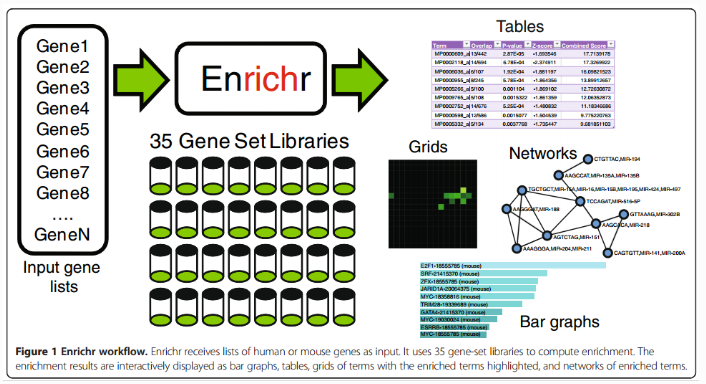


**3.1 Gene Ontology (GO) Enrichment & Pathway Analysis**
<br><br>
Determine the biological functions and pathways that are overrepresented among differentially expressed proteins.<br>
This can provide insights into the broader biological context of the observed changes and identify potential drug targets or biomarkers.

> &#160;<br>
> * Gene Ontology (GO) Enrichment: Identify biological processes, molecular functions, and cellular components that are enriched in differentially expressed proteins.
> * Pathway Analysis: Determine which signaling pathways are activated or inhibited in different polarization states.
> <br><br>&#160;

**3.2 Protein-Protein Interaction Network Analysis**<br><br>
Construct networks to visualize the interactions between proteins and identify protein modules or hubs.<br>
This can help understand how proteins work together to carry out cellular functions and identify key regulatory proteins

### GSEA

Overview of enriched pathways for the two classes separately to understand the broader biological processes involved in each class.

**TODO: DELETE (from here onwards...)**<BR><BR>

**Prerank**<BR>
Prerank is more suitable for comparing different conditions or classes, especially when you have a ranked list of proteins or genes. This method leverages the rank information to identify pathways that are enriched at the extremes of the ranked list.
<BR><BR>
When to use Prerank:
* Comparing Two Classes: If you want to compare the two classes directly and rank the proteins based on differential expression or another relevant metric.
* Enrichment across a Gradient: When you want to identify pathways that are enriched at the top or bottom of a ranked list.
<BR><BR>

**Enrichr**<BR>
Enrichr is best for when you have a list of proteins or genes and you want to find associated biological pathways or processes quickly. It’s more suitable for over-representation analysis, where you check if certain pathways are overrepresented in your list.
<BR><BR>
When to use Enrichr:
* Gene List Analysis: If you have a list of differentially expressed proteins from each class and want to find enriched pathways for each list separately.
* Quick Enrichment: When you need a quick and broad overview of enriched pathways for a given list of proteins.
<BR><BR>

Initial Exploration with Enrichr:
Use Enrichr to get a quick overview of enriched pathways for the two classes separately. This helps you understand the broader biological processes involved in each class.
<BR><BR>
Detailed Analysis with Prerank:
Use Prerank for a more detailed comparison between the two classes. Rank the proteins based on a relevant metric (e.g., log2 fold change) and perform GSEA to identify pathways enriched at the extremes of the ranked list.<BR><BR>

This combined approach will help you capture both the broad overview of enriched pathways and the detailed differences between the two classes in your single-cell proteomics dataset.


In [ ]:
# enrichr library names
lib_names = gp.get_library_name(organism='Mouse')

# print all libraries with "GO" in the name
print("\n".join([lib for lib in lib_names if "allm" in lib]))

In [ ]:

# List of differentially expressed Genes
de_genes = df_huffman_adata_M0.var[df_huffman_adata_M0.var["adj_p_value"] < 0.05]
de_genes


In [ ]:
# Run GSEA
enr_resM0 = gp.enrichr(gene_list=de_genes["Gene"].tolist(),
                    gene_sets=['GO_Biological_Process_2023', 'GO_Cellular_Component_2023', 'GO_Molecular_Function_2023', 'KEGG_2019_Mouse', 'Reactome_2022', 'MSigDB_Hallmark_2020'],
                    organism='Mouse')


In [ ]:
# List of differentially expressed Genes
de_genes = df_huffman_adata_M1.var[df_huffman_adata_M1.var["adj_p_value"] < 0.05]

# Run GSEA
enr_resM1 = gp.enrichr(gene_list=de_genes["Gene"].tolist(),
                    gene_sets=['GO_Biological_Process_2023', 'GO_Cellular_Component_2023', 'GO_Molecular_Function_2023', 'KEGG_2019_Mouse', 'Reactome_2022', 'MSigDB_Hallmark_2020'],
                    organism='Mouse')

In [ ]:
# Dotplot
ax = dotplot(enr_resM0.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=10,
              top_term=5,
              figsize=(5,7),
              title = "Top 5 significant pathways",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=True, # set to False to revmove outer ring
              marker='o',
              cmap="RdPu" #cmap="YlOrRd" #cmap="Blues" #cmap="Greens" #cmap="RdYlBu_r"
             )

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.title('Pathway Enrichment Analysis (GSEA) - M0', fontsize=12)
plt.xlabel('Gene Ratio', fontsize=9)
plt.ylabel('Term', fontsize=9)
plt.show()

In [ ]:
# Dotplot
ax = dotplot(enr_resM1.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=10,
              top_term=5,
              figsize=(5,7),
              title = "Top 5 significant pathways",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=True, # set to False to revmove outer ring
              marker='o',
              cmap="RdPu" #cmap="YlOrRd" #cmap="Blues" #cmap="Greens" #cmap="RdYlBu_r"
             )

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.title('Pathway Enrichment Analysis (GSEA) - M1', fontsize=12)
plt.xlabel('Gene Ratio', fontsize=9)
plt.ylabel('Term', fontsize=9)
plt.show()

In [ ]:
# List of differentially expressed Genes
de_genes = df_huffman_adata.var[df_huffman_adata.var["adj_p_value"] < 0.05]

# Run GSEA
enr_res = gp.enrichr(gene_list=de_genes["Gene"].tolist(),
                    gene_sets=['GO_Biological_Process_2023', 'GO_Cellular_Component_2023', 'GO_Molecular_Function_2023', 'KEGG_2019_Mouse', 'Reactome_2022', 'MSigDB_Hallmark_2020'],
                    organism='Mouse')

In [ ]:
# Dotplot
ax = dotplot(enr_res.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=10,
              top_term=5,
              figsize=(5,7),
              title = "Top 5 significant pathways",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=True, # set to False to revmove outer ring
              marker='o',
              cmap="RdPu" #cmap="YlOrRd" #cmap="Blues" #cmap="Greens" #cmap="RdYlBu_r"
             )

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.title('Pathway Enrichment Analysis (GSEA) - untreated & LPS', fontsize=12)
plt.xlabel('Gene Ratio', fontsize=9)
plt.ylabel('Term', fontsize=9)
plt.show()

In [ ]:
enr_resM0.results.sort_values("Adjusted P-value").head(10)

In [ ]:
enr_resM1.results.sort_values("Adjusted P-value").head(10)

In [ ]:
# Barplot
ax = barplot(enr_resM0.results,
              column="Adjusted P-value",
              group='Gene_set',
              top_term=5,
              figsize=(12,6),
              color = {'Reactome_2022':'#1d3557', 'MSigDB_Hallmark_2020':'#457b9d', 'KEGG_2019_Mouse':'#a8dadc', 'GO_Molecular_Function_2023':'#ffe0b4', 'GO_Cellular_Component_2023':'#ec9a9a', 'GO_Biological_Process_2023': '#e63946', }
             )

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.title('Pathway Enrichment Analysis (GSEA) - M0', fontsize=12)
plt.xlabel('-log10 (Adjusted p-value)', fontsize=9)
plt.ylabel('Term', fontsize=9)
plt.tight_layout()
plt.show()


In [ ]:
# Barplot
ax = barplot(enr_resM1.results,
              column="Adjusted P-value",
              group='Gene_set',
              top_term=5,
              figsize=(12,6),
              color = {'Reactome_2022':'#1d3557', 'MSigDB_Hallmark_2020':'#457b9d', 'KEGG_2019_Mouse':'#a8dadc', 'GO_Molecular_Function_2023':'#ffe0b4', 'GO_Cellular_Component_2023':'#ec9a9a', 'GO_Biological_Process_2023': '#e63946', }
             )

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.title('Pathway Enrichment Analysis (GSEA) - M1', fontsize=12)
plt.xlabel('-log10 (Adjusted p-value)', fontsize=9)
plt.ylabel('Term', fontsize=9)
plt.tight_layout()
plt.show()

In [ ]:
# Barplot
ax = barplot(enr_res.results,
              column="Adjusted P-value",
              group='Gene_set',
              top_term=5,
              figsize=(12,6),
              color = {'Reactome_2022':'#1d3557', 'MSigDB_Hallmark_2020':'#457b9d', 'KEGG_2019_Mouse':'#a8dadc', 'GO_Molecular_Function_2023':'#ffe0b4', 'GO_Cellular_Component_2023':'#ec9a9a', 'GO_Biological_Process_2023': '#e63946', }
             )

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.title('Pathway Enrichment Analysis (GSEA) - untreated & LPS', fontsize=12)
plt.xlabel('-log10 (Adjusted p-value)', fontsize=9)
plt.ylabel('Term', fontsize=9)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(20, 9))
plt.barh(enr_resM0.res2d.index, enr_resM0.res2d['Combined Score'], color='#cedfdf')
plt.xlabel('Combined Score')
plt.title('Pathways Enriched (M0)')

# Significance threshold
plt.axvline(x=COMBINED_SCORE_THRESHOLD, color='red', linestyle='--', label='p-value < 0.05')

for i, term in enumerate(enr_resM0.res2d.index):

    # Concatenate Combined Score and Term
    plt.text(enr_resM0.res2d['Combined Score'][i] +2, i, f"{enr_resM0.res2d['Combined Score'][i]:.2f} - {enr_resM0.res2d['Term'][i]}", va='center', ha='left', fontsize=9)

# grid off
#plt.grid(False)
plt.show()

### Pre-rank GSEA for M0 (2 identified clusters)

Comparison between the two clusters identified in M0.<br>
The goal is to identify pathwas enriched at the extremes of the ranked list

In [ ]:
# List of differentially expressed Genes
de_genes = df_huffman_adata_M0.var[df_huffman_adata_M0.var["adj_p_value"] < 0.05]

In [ ]:
# Compute the RANK metric
pre_input = de_genes[["Gene", "log2fc", "neg_log10_p_value"]]
pre_input["RANK"] = pre_input["neg_log10_p_value"] * pre_input["log2fc"]
print (pre_input)


In [ ]:
pre_input = pre_input[["Gene", "RANK"]]
sorted_genes = pre_input.sort_values('RANK', ascending=False)
sorted_genes.reset_index(drop=True, inplace=True)
sorted_genes

In [ ]:
# TOP 10 up&down-regulated genes. I will use these variables later in the PPI section
de_m0_top_genes = sorted_genes.head(10)
de_m0_down_genes = sorted_genes.tail(10)

In [ ]:
# PRE-rank
pre_res = gp.prerank(rnk=sorted_genes,
                        gene_sets=['GO_Biological_Process_2023', 'GO_Cellular_Component_2023', 'GO_Molecular_Function_2023', 'KEGG_2019_Mouse', 'Reactome_2022', 'MSigDB_Hallmark_2020'],
                        organism='Mouse')


In [ ]:
pre_res.res2d

In [ ]:
terms = pre_res.res2d.Term
axs = pre_res.plot(terms=terms[1:10],
                   show_ranking=True
                  )


https://youtu.be/Yi4d7JIlAsM?si=xvrIooctbV2wMm-P

TODO: **Conclusions**<br><br>
Most of the genes are downregulated as we could see in the section 2.2.4

In [ ]:
pre_res.res2d

In [ ]:
# return two dataframe
nodes, edges = enrichment_map(pre_res.res2d, cutoff=0.5)

G = nx.from_pandas_edgelist(edges,
                            source='src_idx',
                            target='targ_idx',
                            edge_attr=['jaccard_coef', 'overlap_coef', 'overlap_genes'])

fig, ax = plt.subplots(figsize=(18, 9))

def offset_pos(pos, x_offset=0, y_offset=0): 
    return {node: (x + x_offset, y + y_offset) for node, (x, y) in pos.items()}

# init node cooridnates
#pos=nx.layout.spiral_layout(G)
pos=nx.layout.circular_layout(G)


# draw node
nx.draw_networkx_nodes(G,
                       pos=pos,
                       cmap=plt.cm.coolwarm_r, # plt.cm.RdYlBu
                       node_color=list(nodes.NES),
                       node_size=list(nodes.Hits_ratio *1000)
                       )
# draw node label
terms = nodes.Term.to_dict()
terms = {k: v.split('__')[1] for k, v in terms.items()}

# Uncomment the following line to show the full term names
# terms = nodes.Term.to_dict()

nx.draw_networkx_labels(G,
                        pos=offset_pos(pos, x_offset=0.05, y_offset=0.08),
                        labels=terms, # nodes.Term.to_dict()
                        font_size=9)
# draw edge
edge_weight = nx.get_edge_attributes(G, 'jaccard_coef').values()
nx.draw_networkx_edges(G,
                       pos=pos,
                       width=list(map(lambda x: x*10, edge_weight)),
                       edge_color='#CDDBD4')

# grid off
plt.axis('off')

# title
plt.title('Enrichment Map', fontsize=12)
plt.show()

In [ ]:
sign = pre_res.res2d[pre_res.res2d["FDR q-val"] < 0.05]

# Print the top 10 pathways
sign.head(10)

**TODO: Comment why no results**

In [ ]:
# Filter significant pathways
sig_results = pre_res.res2d[pre_res.res2d['FDR q-val'] < 0.25]

print("Number of significant pathways:", sig_results.shape[0])

# Extract pathways and genes
pathway_gene_dict = {}
for idx, row in sig_results.iterrows():
    pathway_gene_dict[row['Term']] = row['Lead_genes'].split(';')


In [ ]:
G = nx.Graph()

# Add nodes and edges to the graph
for pathway, genes in pathway_gene_dict.items():
    G.add_node(pathway, type='pathway')
    for gene in genes:
        G.add_node(gene, type='gene')
        G.add_edge(pathway, gene)

# Ensure positions are generated for all nodes
pos = nx.layout.spring_layout(G)

# Define node colors, sizes, and font sizes based on type
color_map = []
node_size_map = []
font_size_map = {}

for node in G:
    if G.nodes[node]['type'] == 'pathway':
        color_map.append("#f0a202")
        node_size_map.append(1400)  # larger size for pathway nodes
        font_size_map[node] = 12  # larger font size for pathway nodes
    else:
        color_map.append('#2274a5')
        node_size_map.append(800)  # smaller size for gene nodes
        font_size_map[node] = 8  # smaller font size for gene nodes

# Draw the network with custom node sizes and font sizes
plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=node_size_map)
nx.draw_networkx_edges(G, pos, edge_color='gray')

# Draw labels with custom font sizes
for node, (x, y) in pos.items():
    if G.nodes[node]['type'] == 'pathway':
        label = node.split('__')[1]

        # Uncomment if you want to see the full pathway name
        # label = node
        nx.draw_networkx_labels(G, {node: (x, y)}, labels={node: label}, font_size=font_size_map[node], font_weight='bold')
    else:
        nx.draw_networkx_labels(G, {node: (x, y)}, labels={node: node}, font_size=font_size_map[node], font_color='white')

plt.title('Gene-Pathway Network (M0)')
# Remove grid
plt.axis('off')
plt.show()



In [ ]:
# Create a graph
G = nx.Graph()

# Add nodes and edges to the graph
for pathway, genes in pathway_gene_dict.items():
    G.add_node(pathway, type='pathway')
    for gene in genes:
        G.add_node(gene, type='gene')
        G.add_edge(pathway, gene)

# Initialize Pyvis Network
net = Network(height='1100px', width='100%', bgcolor='#ffffff', font_color='black', select_menu=True)

# Add nodes and edges to Pyvis Network
for node, data in G.nodes(data=True):
    label = node
    if data['type'] == 'pathway':
        label = node.split('__')[1]

        # Uncomment if you want to see the full pathway name
        # label = node        
        net.add_node(node, label=label, color='skyblue', size=30, font={'size': 20})
    else:
        net.add_node(node, label=node, color='lightgreen', size=15, font={'size': 12})

for edge in G.edges():
    net.add_edge(edge[0], edge[1], color='gray')

# Plot the network
net.save_graph("pathway_gene_network_M0.html")

👉🏻 You can open the file by clicking this [link](pathway_gene_network_M0.html) 

### Pre-rank GSEA M1

In [ ]:
# List of differentially expressed Genes
de_genes = df_huffman_adata_M1.var[df_huffman_adata_M1.var["adj_p_value"] < 0.05]

# Compute the RANK metric
pre_input = de_genes[["Gene", "log2fc", "neg_log10_p_value"]]
pre_input["RANK"] = pre_input["neg_log10_p_value"] * pre_input["log2fc"]
print (pre_input)

pre_input = pre_input[["Gene", "RANK"]]
sorted_genes = pre_input.sort_values('RANK', ascending=False)
sorted_genes.reset_index(drop=True, inplace=True)

# TOP 10 up&down-regulated genes. I will use these variables later in the PPI section
de_m1_top_genes = sorted_genes.head(10)
de_m1_down_genes = sorted_genes.tail(10)

### Pre-rank GSEA M0 vs M1


In [ ]:
# List of differentially expressed proteins
de_genes = df_huffman_adata.var[df_huffman_adata.var["adj_p_value"] < 0.05]
de_genes

In [ ]:
# Pre-rank
pre_input = de_genes[["Gene", "log2fc", "neg_log10_p_value"]]
pre_input["RANK"] = pre_input["neg_log10_p_value"] * pre_input["log2fc"]
pre_input = pre_input[["Gene", "RANK"]]
print (pre_input)


In [ ]:
# Sort the proteins by rank
sorted_genes = pre_input.sort_values('RANK', ascending=False)
sorted_genes = sorted_genes.reset_index(drop=True)
sorted_genes

# TOP 10 up&down-regulated genes. I will use these variables later in the PPI section
de_top_genes = sorted_genes.head(10)
de_down_genes = sorted_genes.tail(10)


In [ ]:
# PRE-rank
pre_res = gp.prerank(rnk=sorted_genes,
                        gene_sets=['GO_Biological_Process_2023', 'GO_Cellular_Component_2023', 'GO_Molecular_Function_2023', 'KEGG_2019_Mouse', 'Reactome_2022', 'MSigDB_Hallmark_2020'],
                        organism='Mouse')

In [ ]:
pre_res.res2d

In [ ]:
terms = pre_res.res2d.Term
axs = pre_res.plot(terms=terms[1:10],
                   show_ranking=True
                  )

In [ ]:
sign = pre_res.res2d[pre_res.res2d["FDR q-val"] < 0.05]

# Print the top 10 pathways
sign.head(10)

In [ ]:
# Filter significant pathways
sig_results = pre_res.res2d[pre_res.res2d['FDR q-val'] < 0.25]

print("Number of significant pathways:", sig_results.shape[0])

# Extract pathways and genes
pathway_gene_dict = {}
for idx, row in sig_results.iterrows():
    pathway_gene_dict[row['Term']] = row['Lead_genes'].split(';')

In [ ]:
# Create a graph
G = nx.Graph()

# Add nodes and edges to the graph
for pathway, genes in pathway_gene_dict.items():
    G.add_node(pathway, type='pathway')
    for gene in genes:
        G.add_node(gene, type='gene')
        G.add_edge(pathway, gene)

# Initialize Pyvis Network
net = Network(height='1100px', width='100%', bgcolor='#ffffff', font_color='black', select_menu=True)

# Add nodes and edges to Pyvis Network
for node, data in G.nodes(data=True):
    if data['type'] == 'pathway':
        net.add_node(node, label=node, color='skyblue', size=30, font={'size': 20})
    else:
        net.add_node(node, label=node, color='lightgreen', size=15, font={'size': 12})

for edge in G.edges():
    net.add_edge(edge[0], edge[1], color='gray')

# Plot the network
net.save_graph("pathway_gene_network_M0_M1.html")

👉🏻 You can open the file by clicking this [link](pathway_gene_network_M0_M1.html)

### Protein-Protein Interaction


In [ ]:
sdb = StringDBClient(server_url="https://string-db.org/api", species=9606, score_threshold=400)

**PPI for untreated cells**

In [ ]:
# Most up-regulated genes
input_list = de_m0_top_genes["Gene"].tolist()
image_data = sdb.get_network_image(input_list, "image")
page = sdb.get_protein_page(input_list, "tsv-no-header")
print("Link to the information page of the proteins: "+page)
display(Image(image_data))

In [ ]:
# Most down-regulated genes
input_list = de_m0_down_genes["Gene"].tolist()
image_data = sdb.get_network_image(input_list, "image")
page = sdb.get_protein_page(input_list, "tsv-no-header")
print("Link to the information page of the proteins: "+page)
display(Image(image_data))

In [ ]:
# Most up&down-regulated genes
input_list = de_m0_top_genes["Gene"].tolist() + de_m0_down_genes["Gene"].tolist()
image_data = sdb.get_network_image(input_list, "image")
page = sdb.get_protein_page(input_list, "tsv-no-header")
print("Link to the information page of the proteins: "+page)
display(Image(image_data))

**PPI for LPS cells**

In [ ]:
# Most up-regulated genes
input_list = de_m1_top_genes["Gene"].tolist()
image_data = sdb.get_network_image(input_list, "image")
page = sdb.get_protein_page(input_list, "tsv-no-header")
print("Link to the information page of the proteins: "+page)
display(Image(image_data))

In [ ]:
# Most down-regulated genes
input_list = de_m1_down_genes["Gene"].tolist()
image_data = sdb.get_network_image(input_list, "image")
page = sdb.get_protein_page(input_list, "tsv-no-header")
print("Link to the information page of the proteins: "+page)
display(Image(image_data))

In [ ]:
# Most up&down-regulated genes
input_list = de_m1_top_genes["Gene"].tolist() + de_m0_down_genes["Gene"].tolist()
image_data = sdb.get_network_image(input_list, "image")
page = sdb.get_protein_page(input_list, "tsv-no-header")
print("Link to the information page of the proteins: "+page)
display(Image(image_data))

**PPI for M0 & M1**

In [ ]:
# Most up-regulated genes
input_list = de_top_genes["Gene"].tolist()
image_data = sdb.get_network_image(input_list, "image")
page = sdb.get_protein_page(input_list, "tsv-no-header")
print("Link to the information page of the proteins: "+page)
display(Image(image_data))

In [ ]:
# Most down-regulated genes
input_list = de_down_genes["Gene"].tolist()
image_data = sdb.get_network_image(input_list, "image")
page = sdb.get_protein_page(input_list, "tsv-no-header")
print("Link to the information page of the proteins: "+page)
display(Image(image_data))

In [ ]:
# Most up&down-regulated genes
input_list = de_top_genes["Gene"].tolist() + de_down_genes["Gene"].tolist()
image_data = sdb.get_network_image(input_list, "image")
page = sdb.get_protein_page(input_list, "tsv-no-header")
print("Link to the information page of the proteins: "+page)
display(Image(image_data))